MSE 597: Project 2
Molecular Dynamics

The goal of this project is to provide hands-on experience with molecular dynamics to investigate the structure of a material system. The system must be off-lattice in 3D, and using HOOMD-Blue is highly recommended. Your challenge in this project is to solve the following prompts and questions:

1. Pick a one or two-component system you’re curious about (e.g., Argon, copper, nickel, etc)
2. Search the literature to see which interaction potentials have been used to study this, or similar systems in the past. Summarize these 2-6 papers in your iPython notebook, and pick a “control” potential to start with.
3. Characterize your model’s performance:
a. How long does it take to equilibrate?
b. How small is too small? How big is too big?
4. What do the results of this model teach us about the world?
a. What thermodynamic observables can you calculate? Calculate them. Are there any surprises here?
b. Are there any structures that form at any of the state point you’ve sampled? How do these observations help us understand the physical system you’re modeling?
5. Try out another interaction potential (can be totally different, informed by a hypothesis, anything, even tabulated potentials that you make up) to see how your results from 3 and 4 differ with a different interaction potential.
 
Due Date: 5:00pm, March 30, 2017

Deliverables:  An iPython notebook with your code, analysis, and project summary.


In [1]:
import hoomd, hoomd.md
from hoomd import deprecated
import mbuild as mb
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from IPython.display import Image
#%matplotlib inline

In [2]:
def gen_bond(r, rmin, rmax, f = 7.614, beta=1.535, r0=2.4805, D=8.2589109):
    E = f*D*(np.exp(-2*beta*(r-r0))-2*np.exp(-1*beta*(r-r0)))
    F = -f*D*(-2*beta*np.exp(-2*beta*(r-r0))+2*beta*np.exp(-1*beta*(r-r0)))
    return E,F

In [3]:
def interaction(r, rmin, rmax, f, a1, b1, c1, a2, b2, c2):
    E = f*(b1+b2)*np.exp((a1+a2-r)/(b1+b2))-(c1*c2)/(r**6)
    F = -1*(-1*f*(b1+b2)*np.exp((a1+a2-r)/(b1+b2))+6*(np.sqrt(c1*c2))/(r**7))
    return E,F

In [4]:
def new_interaction(r, rmin, rmax, sigma):
    E = (sigma/r)**6
    F = -6*(sigma/r)**7
    return E, F

In [5]:
class Link(mb.Compound):
    def __init__(self):
        super(Link, self).__init__()
        U = mb.Particle(name='U')
        self.add(U, label='U[$]')

        C = mb.Particle(name='C', pos=[0.24805, 0, 0])
        self.add(C, label='UC[$]')
        self.add_bond((self[0], self['UC'][0]))

In [6]:
class run_system():
    def __init__(self, T, updated = False):
        self.T = T
        self.updated = updated
        
    def start(self, run_name):    
        hoomd.context.initialize('mode=cpu')
        system = hoomd.deprecated.init.read_xml("mol.hoomdxml")
        for part in system.particles:
            if part.type == 'U':
                part.diameter = 3.836
                part.charge = 0.9600*33
            if part.type == 'C':
                part.diameter = 2.226
                part.charge = -0.9600*33

        nl = hoomd.md.nlist.cell()

        #btable = hoomd.md.bond.table(width = 1000)
        #btable.bond_coeff.set('0', func=gen_bond, rmin=0.3, rmax=100., coeff=dict(f = 7.614, beta=1.535, r0=2.4805, D=8.2589109))

        table = hoomd.md.pair.table(width=1000, nlist = nl)
        if self.updated:
            table.pair_coeff.set('U', 'U', func=new_interaction, rmin=0.5, rmax=3.836, coeff=dict(sigma = 3.836))
            table.pair_coeff.set('U', 'C', func=new_interaction, rmin=0.5, rmax=(3.836+2.226)/2, coeff=dict(sigma = ((3.836+2.226)/2)))
            table.pair_coeff.set('C', 'C', func=new_interaction, rmin=0.5, rmax=2.226, coeff=dict(sigma = 2.226))
        else:
            table.pair_coeff.set('U', 'U', func=interaction, rmin=0.08, rmax=9.36, coeff=dict(f=7.6148055, a1=3.836, b1=0.2627776, c1=0.0, a2=3.836, b2=0.2627776, c2=0.0))
            table.pair_coeff.set('C', 'U', func=interaction, rmin=0.08, rmax=9.36, coeff=dict(f=7.6148055, a1=2.226, b1=0.2627776, c1=270.0, a2=3.836, b2=0.2627776, c2=0.0))
            table.pair_coeff.set('C', 'C', func=interaction, rmin=0.2226, rmax=9.36, coeff=dict(f=7.6148055, a1=2.226, b1=0.2627776, c1=270.0, a2=2.226, b2=0.2627776, c2=270.0))

        all = hoomd.group.all()
        charged = hoomd.group.charged();
        pppm = hoomd.md.charge.pppm(group=charged, nlist = nl)
        pppm.set_params(Nx=8, Ny=8, Nz=8, order=6, rcut=3.0*3.836)

        hoomd.md.integrate.mode_standard(dt=0.001, aniso = False)


        hoomd.md.integrate.nvt(group=all, kT=self.T, tau=4)
        if self.updated:
            hoomd.deprecated.dump.xml(group = hoomd.group.all(), filename = 'out_files/updated/'+run_name+"-out.hoomdxml", all=True)
            hoomd.dump.dcd(filename = 'out_files/updated/'+run_name+"-traj.dcd", period = 1e3, overwrite = True)
            hoomd.analyze.log(filename = 'out_files/updated/'+run_name+'-log', quantities = ['potential_energy', 'kinetic_energy', 'pressure','temperature', 'volume','pair_table_energy','pppm_energy'], period = 1e3, header_prefix = '#', overwrite = True)
        else:
            hoomd.deprecated.dump.xml(group = hoomd.group.all(), filename = 'out_files/'+run_name+"-out.hoomdxml", all=True)
            hoomd.dump.dcd(filename = 'out_files/'+run_name+"-traj.dcd", period = 1e3, overwrite = True)
            hoomd.analyze.log(filename = 'out_files/'+run_name+'-log', quantities = ['potential_energy', 'kinetic_energy', 'pressure','temperature', 'volume','pair_table_energy','pppm_energy'], period = 1e3, header_prefix = '#', overwrite = True)     
        #hoomd.dump.gsd(group = hoomd.group.all(), filename = run_name+'-out.gsd', period = 1e3)
        hoomd.run(5e4)

In [7]:
class rdf():
    def __init__(self, pos_array, axes, plot, expand):
        self.bins = 100
        #Multiply by 10 to convert to Angstroms to match force-field.
        self.axes = axes*10
        pos_array = pos_array*10
        self.rho = 400/(self.axes[0]**3)
        UU = self.calc_systems(pos_array[0:-1:2,:])
        CC = self.calc_systems(pos_array[1:-1:2,:])
        UC = self.calc_UC(pos_array[0:-1:2,:], pos_array[1:-1:2,:])
        if plot:
            self.plot_rdf(UU, CC, UC)
        if expand:
            return UU, CC, UC
    
    def plot_rdf(self, UU, CC, UC):
        plt.close()
        plt.plot(UU[:,0], UU[:,1]/10, label='UU')
        plt.plot(CC[:,0], CC[:,1]/10, label='CC')
        plt.plot(UC[:,0], UC[:,1]/10, label='UC')
        plt.xlabel('r (A)')
        plt.ylabel('g(r)')
        plt.xlim([0,20])
        plt.legend()
        save = input("Would you like to save input? (y or n)\n")
        if save == 'y':
            name = input("name?.png >")
            plt.savefig(name+".png")
        plt.show()
        plt.close()        
    
    def normalize(self, distribution):
        rdf = []
        for i in range(len(distribution[0])):
            start = 0.0
            end = distribution[1][i]
            point = distribution[0][i]/(self.rho*4/3*np.pi*(end**3-start**3))
            start = distribution[1][i]
            rdf.append([end, point])
        rdf = np.array(rdf)
        return rdf
        
    def calc_systems(self, pos_array):
        d_list = []
        for i in range(len(pos_array)-1):
            for j in range(i, len(pos_array)):
                d = self.distances(pos_array[i],pos_array[j])
                if d>1.:
                    d_list.append(d)
        distribution = np.histogram(d_list, self.bins)
        rdf = self.normalize(distribution)
        return rdf
     
    def calc_UC(self, start, pos_array):
        d_list = []
        for i in range(len(pos_array)):
            for j in range(len(start)):
                d = self.distances(start[j],pos_array[i])
                if d > 3.9400:
                    #To eliminate the bonded U-C
                    d_list.append(d)
        distribution = np.histogram(d_list, self.bins)
        rdf = self.normalize(distribution)
        return rdf
    
    def pbc(self, vec):
        for i,v in enumerate(vec):
            if v>self.axes[i]/2.:
                vec[i]-=self.axes[i]
            if v<-self.axes[i]/2.:
                vec[i]+=self.axes[i]
        return vec

    def distances(self, vec1, vec2):
        diff = self.pbc(vec1-vec2)
        dist = np.linalg.norm(diff)
        return dist

In [8]:
class energy(rdf):
    def __init__(self, pos_array, axes, N, V, plot):
        UU, CC, UC = rdf.__init__(self, pos_array, axes, plot, expand = True)
        E = self.calc_E(UU, a1=3.836, c1=0.0, a2=3.836, c2=0.0, q1 = 0.93, q2 = 0.93)
        #print("Energy from U-U interactions:", E)        
        E+= self.calc_E(CC, a1=2.226, c1=270.0, a2=3.836, c2=0.0, q1 = -0.93, q2 = -0.93)
        #print("Energy with C-C interactions:", E)
        E+= self.calc_E(UC, a1=2.226, c1=270.0, a2=2.226, c2=270.0, q1 = -0.93, q2 = 0.93)
        print("The Non-Bonded Energy of the system is: {:.2f} kJ/mol".format(E/1000))
        
    def calc_E(self, data, a1, a2, c1, c2, q1, q2, f=7.6148, b1=0.26278, b2=0.26278):
        E = 0
        for R in range(1,len(data[:,1])):
            r = data[R,0]
            e = 0
            e += f*(b1+b2)*np.exp((a1+a2-r)/(b1+b2))
            e -= np.sqrt(c1*c2)/((r)**6)
            e -= q1*q2*(1.6e-19**2)/(8.854e-12*4*np.pi*r)
            e *= data[R,1]
            e *= 4*np.pi*(r*1e-10)**2
            #Adding 4pir**2, converting this value to Anstroms to mach other units
            e *= (data[R,0]-data[R-1,0])
            E += e
            #print("core:", f*(b1+b2)*np.exp((a1+a2-r)/(b1+b2)))
            #print("van der Waals:", -c1*c2/((r)**6))
            #print("electro", q1*q2*(1.6e-19**2)/(8.854e-12*4*np.pi*r*1e-10))
            #print("g(r)", data[R,1])
            #print("dr",((data[R,0]-data[R-1,0])))
            #print("Energy added this round", e)
        E = E*(200**2)/((self.axes[0])**3)*(6.022e23/200)
        #print("FINAL!", E)
        return E
            

In [9]:
class pressure(rdf):
    def __init__(self, pos_array, axes, N, V, kT, plot):
        UU, CC, UC = rdf.__init__(self, pos_array, axes, plot, expand = True)
        self.kT = kT
        self.density = self.calc_density(N,V)
        ppUU = self.pp(UU, a1=3.836, c1=0.0, a2=3.836, c2=0.0, q1 = 0.93, q2 = 0.93)
        ppCC = self.pp(CC, a1=2.226, c1=270.0, a2=3.836, c2=0.0, q1 = -0.93, q2 = -0.93)
        ppUC = self.pp(UC, a1=2.226, c1=270.0, a2=2.226, c2=270.0, q1 = -0.93, q2 = 0.93)
        self.total_P = self.get_total(ppUU, ppCC, ppUC)
        print("The pressure of the system is: {:.2f} atm".format(self.total_P/101325))

    def value(self):
        return self.total_P/101325
    
    def get_total(self, ppUU, ppCC, ppUC):
        P = self.density*self.kT*1000/0.250-(ppUU+ppCC+ppUC)*6.022e23*1000
        return P

    def pp(self, data, a1, a2, c1, c2, q1, q2, f=7.6148, b1=0.26278, b2=0.26278):
        P = 0
        for R in range(1,len(data[:,1])-1):
            r = data[R,0]
            p = 0
            p -= f*np.exp((a1+a2-r)/(b1+b2))
            p += 6*np.sqrt(c1*c2)/((r)**7)
            p += q1*q2*(1.6e-19**2)/(8.854e-12*4*np.pi*r**2)
            p *= data[R,1]
            p *= 4*np.pi*(r*1e-10)**3
            p *= ((data[R,0]-data[R-1,0]))
            P += p
        P *= (self.density**2)/6
        return P  
    
    def calc_density(self, N, V):
        rho = (N*250.04/6.022e23)/(V*(1e-7)**3)
        return rho

In [10]:
#x = np.linspace(2.2, 5, 1000)
#E, F = gen_bond(r = x, rmin = 1, rmax = 4.0)
#plt.plot(x, E, label = "Energy")
#plt.plot(x, F, label = "Force")
#plt.legend(loc = 'best')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E and F")

In [11]:
#def coulomb(r, z1= 0.96, z2 = -0.96):
#    E = z1*z2/r
#    return E
#    
#r = np.linspace(0.5, 5., 100)
#E = coulomb(r)
#plt.plot(r, E, label = "Energy", marker = '.')
#plt.legend(loc = 'lower right')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E")

In [12]:
#def core(r, f=7.614, a1=2.226, a2=2.226, b1=0.262, b2=0.262):
#    E = f*(b1+b2)*np.exp((a1+a2-r)/(b1+b2))
#    return E
#    
#r = np.linspace(2, 5., 100)
#E = core(r)
#plt.plot(r, E, label = "Energy", marker = '.')
#plt.legend(loc = 'best')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E")

In [13]:
#def vanderWaals(r, c1 = 270, c2 = 270):
#    E = -c1/(r**6)
#    return E
#    
#r = np.linspace(2.0, 5., 100)
#E = vanderWaals(r)
#plt.plot(r, E, label = "Energy", marker = '.')
#plt.legend(loc = 'lower right')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E")

In [14]:
#def fourth(r, f=7.614, D=8.26, beta=1.535, r0=2.4805):
#    E = f*D*(np.exp(-2*beta*(r-r0))-2*np.exp(-beta*(r-r0)))
#    return E
    
#r = np.linspace(2, 5., 100)
#E = fourth(r)
#plt.plot(r, E, label = "Energy", marker = '.')
#plt.legend(loc = 'best')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E")

In [15]:
#r = np.linspace(2, 4, 50)
#E,F = interaction(r, rmin = 0.0, rmax = 3.0, f=7.6148055, a1=2.226, b1=0.2627776, c1=270.0, a2=2.226, b2=0.2627776, c2=270.0)
#plt.plot(r, E, label = "Energy", marker = '.')
#plt.plot(r, F/1e6, label = "Force", marker = '.')
#plt.legend(loc = 'best')
#plt.xlabel("Radius (Angstrom)")
#plt.ylabel("E and F, (1e6)")

In [16]:
#%%capture out.txt
#for sys in sizes:
#    #L = 0.04*sys
#    L = 3.0
#    mol = Link()
#    N = sys
#    system = mb.fill_box(mol, n_compounds = N, overlap = 0.5, box = [L, L, L])
#    system.save('mol.hoomdxml')
#    go = run_system(T=10)
#    go.start(str(sys))
    #with open('out_files/'+str(sys)+'-output.txt','w') as f:
        #f.write(out.stdout)

In [17]:
new = [3, 6, 9, 12]

#for T in new:
#    L = 3.0
#    mol = Link()
#    N = 200
#    system = mb.fill_box(mol, n_compounds = N, overlap = 0.5, box = [L, L, L])
#    system.save('mol.hoomdxml')
#    run = run_system(T, updated = True)
#    run.start(str(T))

In [18]:
L = 3.0
N = 200
#system = mb.fill_box(mol, n_compounds = N, overlap = 0.5, box = [L, L, L])
#system.save('mol.hoomdxml')
#run = run_system(T, updated = False)
#run.start("no_bond")

Would you like to save input? (y or n)
n


/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


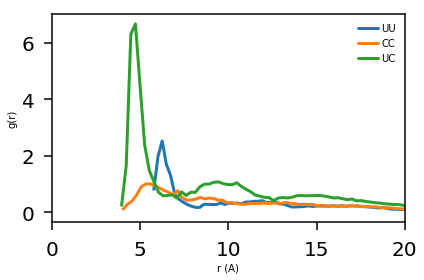

The Non-Bonded Energy of the system is: 19644.27 kJ/mol
The pressure of the system is: 0.95 atm


In [20]:
Top_file = "out_files/"+"no_bond"+"-out.hoomdxml"
Traj_file = "out_files/"+'no_bond'+"-traj.dcd"
t = md.load(Traj_file, top=Top_file)
axes = t.unitcell_lengths[t.n_frames-1]
pos = t.xyz[t.n_frames-1, 0:-1:1,:]
g_R = rdf(pos, axes, plot = True, expand = False)
g_R = energy(pos, axes, V=axes[0]**3, N=200, plot = False)
g_R = pressure(pos, axes, V=axes[0]**3, N=200, kT = 12, plot = False)

Would you like to save input? (y or n)
n


/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


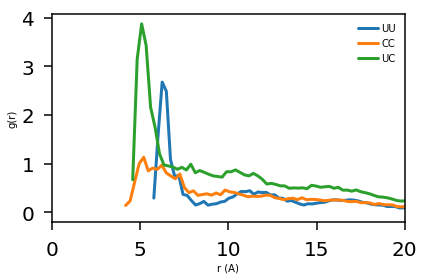

The Non-Bonded Energy of the system is: 18800.01 kJ/mol
The pressure of the system is: 0.26 atm


In [22]:
Top_file = "out_files/T_runs/"+"3"+"-out.hoomdxml"
Traj_file = "out_files/T_runs/"+'3'+"-traj.dcd"
t = md.load(Traj_file, top=Top_file)
axes = t.unitcell_lengths[t.n_frames-1]
pos = t.xyz[t.n_frames-1, 0:-1:1,:]
g_R = rdf(pos, axes, plot = True, expand = False)
g_R = energy(pos, axes, V=axes[0]**3, N=200, plot = False)
g_R = pressure(pos, axes, V=axes[0]**3, N=200, kT = 3, plot = False)


In [23]:
sizes = [50,100,150,200]
plt.close()
for run in sizes:
    a = np.loadtxt('out_files/'+str(run)+"-log", skiprows = 1)
    plt.plot(a[:,0]/1000, a[:,1]-np.mean(a[:,1]), label = str(run))
    plt.xlim([0,50])
    plt.xlabel('timestep (1e3)')
    plt.ylabel('E (normalized)')
    plt.legend()
plt.savefig("EvT.png")

In [24]:
TPS = [740,350,225,165]
func = np.polyfit(sizes, TPS, 1)
#print(func)
xs = np.linspace(50, 200, 20)
plt.close()
plt.plot(sizes, TPS, 'o')
plt.plot(xs, xs*func[0]+func[1], '.')
plt.xlabel('system size')
plt.ylabel('TPS')
plt.savefig("TPSvSize.png")

In [34]:
%%capture out.txt
from scipy.optimize import curve_fit
T_list = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


def func(x, a, b, c, d, e):
    return a + b*x +c*(x**2) + d*(x**3) + e*(x**4)

def run_temps(T_list):

    for Temp in T_list:
        L = 3.0
        mol = Link()
        N = 200
        system = mb.fill_box(mol, n_compounds = N, overlap = 0.5, box = [L, L, L])
        system.save('mol.hoomdxml')
        go = run_system(T=Temp)
        go.start("T_runs/"+str(Temp))

def plot_temps(T_list):
    plt.close()
    U = []
    for Temp in T_list:
        x = Temp
        y = U.append(np.mean(np.loadtxt('out_files/T_runs/'+str(Temp)+'-log')[20:,6]))
    popt, pcov = curve_fit(func, T_list, U, p0=(151, 36, 98, 10, 10))
    xx = np.linspace(1,T_list[-1],1000)
    plt.plot(T_list, U, 'o')
    plt.grid()
    plt.plot(xx, func(xx, *popt))
    plt.xlabel("T (229 K)")
    plt.ylabel("Energy (kJ/mol)")
    plt.savefig("UVT.png")
    
#run_temps(T_list)

In [35]:
plot_temps(T_list)

In [27]:
%%capture out.txt
def PVT(T_list):
    P_list = []
    for T in T_list:
        Top_file = "out_files/T_runs/"+str(T)+"-out.hoomdxml"
        Traj_file = "out_files/T_runs/"+str(T)+"-traj.dcd"
        t = md.load(Traj_file, top = Top_file)
        axes = t.unitcell_lengths[t.n_frames-1]
        ps = t.xyz[t.n_frames-1, 0:-1:1,:]
        P = pressure(pos, axes, V = axes[0]**3, N=200, kT = T, plot = False).value()
        P_list.append(P)
    return P_list

def plot_Ps(T_list, P_list):
    plt.close()
    plt.plot(T_list, P_list)
    plt.xlabel("Temperature (229 K)")
    plt.ylabel("Presssure (atm)")
    plt.savefig("PvT.png")
    plt.show()

P_list = PVT(T_list)


/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


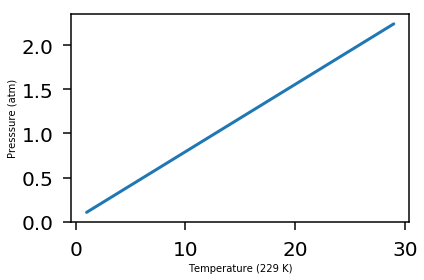

In [28]:
#print(P_list)
plot_Ps(T_list, P_list)

Would you like to save input? (y or n)
n


/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


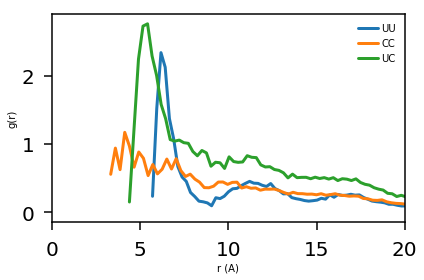

The Non-Bonded Energy of the system is: 31154.92 kJ/mol
The pressure of the system is: 0.80 atm


In [29]:
U_distance = []

for run in range(len(sizes)-3):
    size = sizes[run+3]
    Top_file = "out_files/"+str(size)+"-out.hoomdxml"
    Traj_file = "out_files/"+str(size)+"-traj.dcd"
    t = md.load(Traj_file, top=Top_file)
    axes = t.unitcell_lengths[t.n_frames-1]
    pos = t.xyz[t.n_frames-1, 0:-1:1,:]
    g_R = rdf(pos, axes, plot = True, expand = False)
    g_R = energy(pos, axes, V=axes[0]**3, N=size, plot = False)
    g_R = pressure(pos, axes, V=axes[0]**3, N=size, kT = 10, plot = False)


## 1

I have chosen to look at the Uranium-Carbide system.

## 2

The main source I will use in this work is by Basak "Classical molecular dynamics simulation of uranium monocarbide (UC)" DOI:10.1016/j.commatsci.2007.02.009. I also look at papers containing Uranium compounds, normally, UO2 is the compound of interest, such as another work by Basak, DOI:10.1016/S0925-8388(03)00350-5 and Yamada DOI:10.1016/S0925-8388(00)00806-9. These works involve the same force-field used in the initial paper, termed "Partially Ionic Model:"

\begin{equation}
\phi_{i,j}(r_{i,j}) = 
\frac{z_{i} z_{j} e^2}{r_{i,j}}
+ f_{0}(b_{i} + b_{j}) exp \Big(\frac{a_{i} + a_{j} - r_{i,j}}{b_i+b_j}\Big)
- \frac{c_{i} c_{j}}{r_{i,j}^6} \\
+ f_{0} D_{i,j} 
\Big[ exp \Big\{ -2 \beta_{i,j} (r_{i,j} - r_{i,j}^{*}) \Big\} 
-2 exp \Big\{- \beta_{i,j} (r_{i,j}- r_{i,j}^{*}) \Big\} \Big],
\end{equation}

in which the first term is the Coulombic interaction, the second term accounts for the core repulsions between the ions, the third term is van der Waals interactions and the fourth is the Morse-like bonding potential in U-C bonds.

It should be noted that the coefficients presented in these papers normally don't have units to accompany them. 
In fact, the UO2 paper by Basak was the only paper that gives units and these units are somewhat questionable. 
For example, the van der walls interaction is given in units of $c=(\times 10^{19} J A^{-6})$, which when squared and divided by $r^6$ would result in units of $A^{-18}$, and would overpower any of the other parameters. 
I tried to track down the original citation with these parameters, but they are contained in a textbook which I couldn't find online and couldn't find on interlibrary loan.
However, the paper says that using the numbers given results in units of kJ/mol, therefore, I assume this is correct when I use the tabulated interactions.

In these works, the authors calculate the lattice parameters and thermal expansion coefficients. 
These works report results that are close to results measured experimentally.


## 3

In terms of performance, the system seems to be very slow. 
This is due to the inclusion of charges (which I didn't think could be omitted in a "partially ionic model"). 
When charges are excluded, TPS increases by a factor or 8.
Additionally, because I use the force-field as it is given in the papers, I normalize by the units of m = 1 amu, $\epsilon$ = 1kj/mol, and $\sigma$ = 1 Angstrom.
As a result of this, my $r_{cut}$ had be be large, ~10 A or atoms would fail to interact properly, and with the increased $r_{cut}$, the calculations were slower.

I ran systems of 50, 100, 150 and 200 molecules. For all these systems, they converged to equilibrium by 20,000 timesteps. The systems had timesteps per second of 740, 350, 225 and 165 for the 50, 100, 150 and 200 molecule systems. 


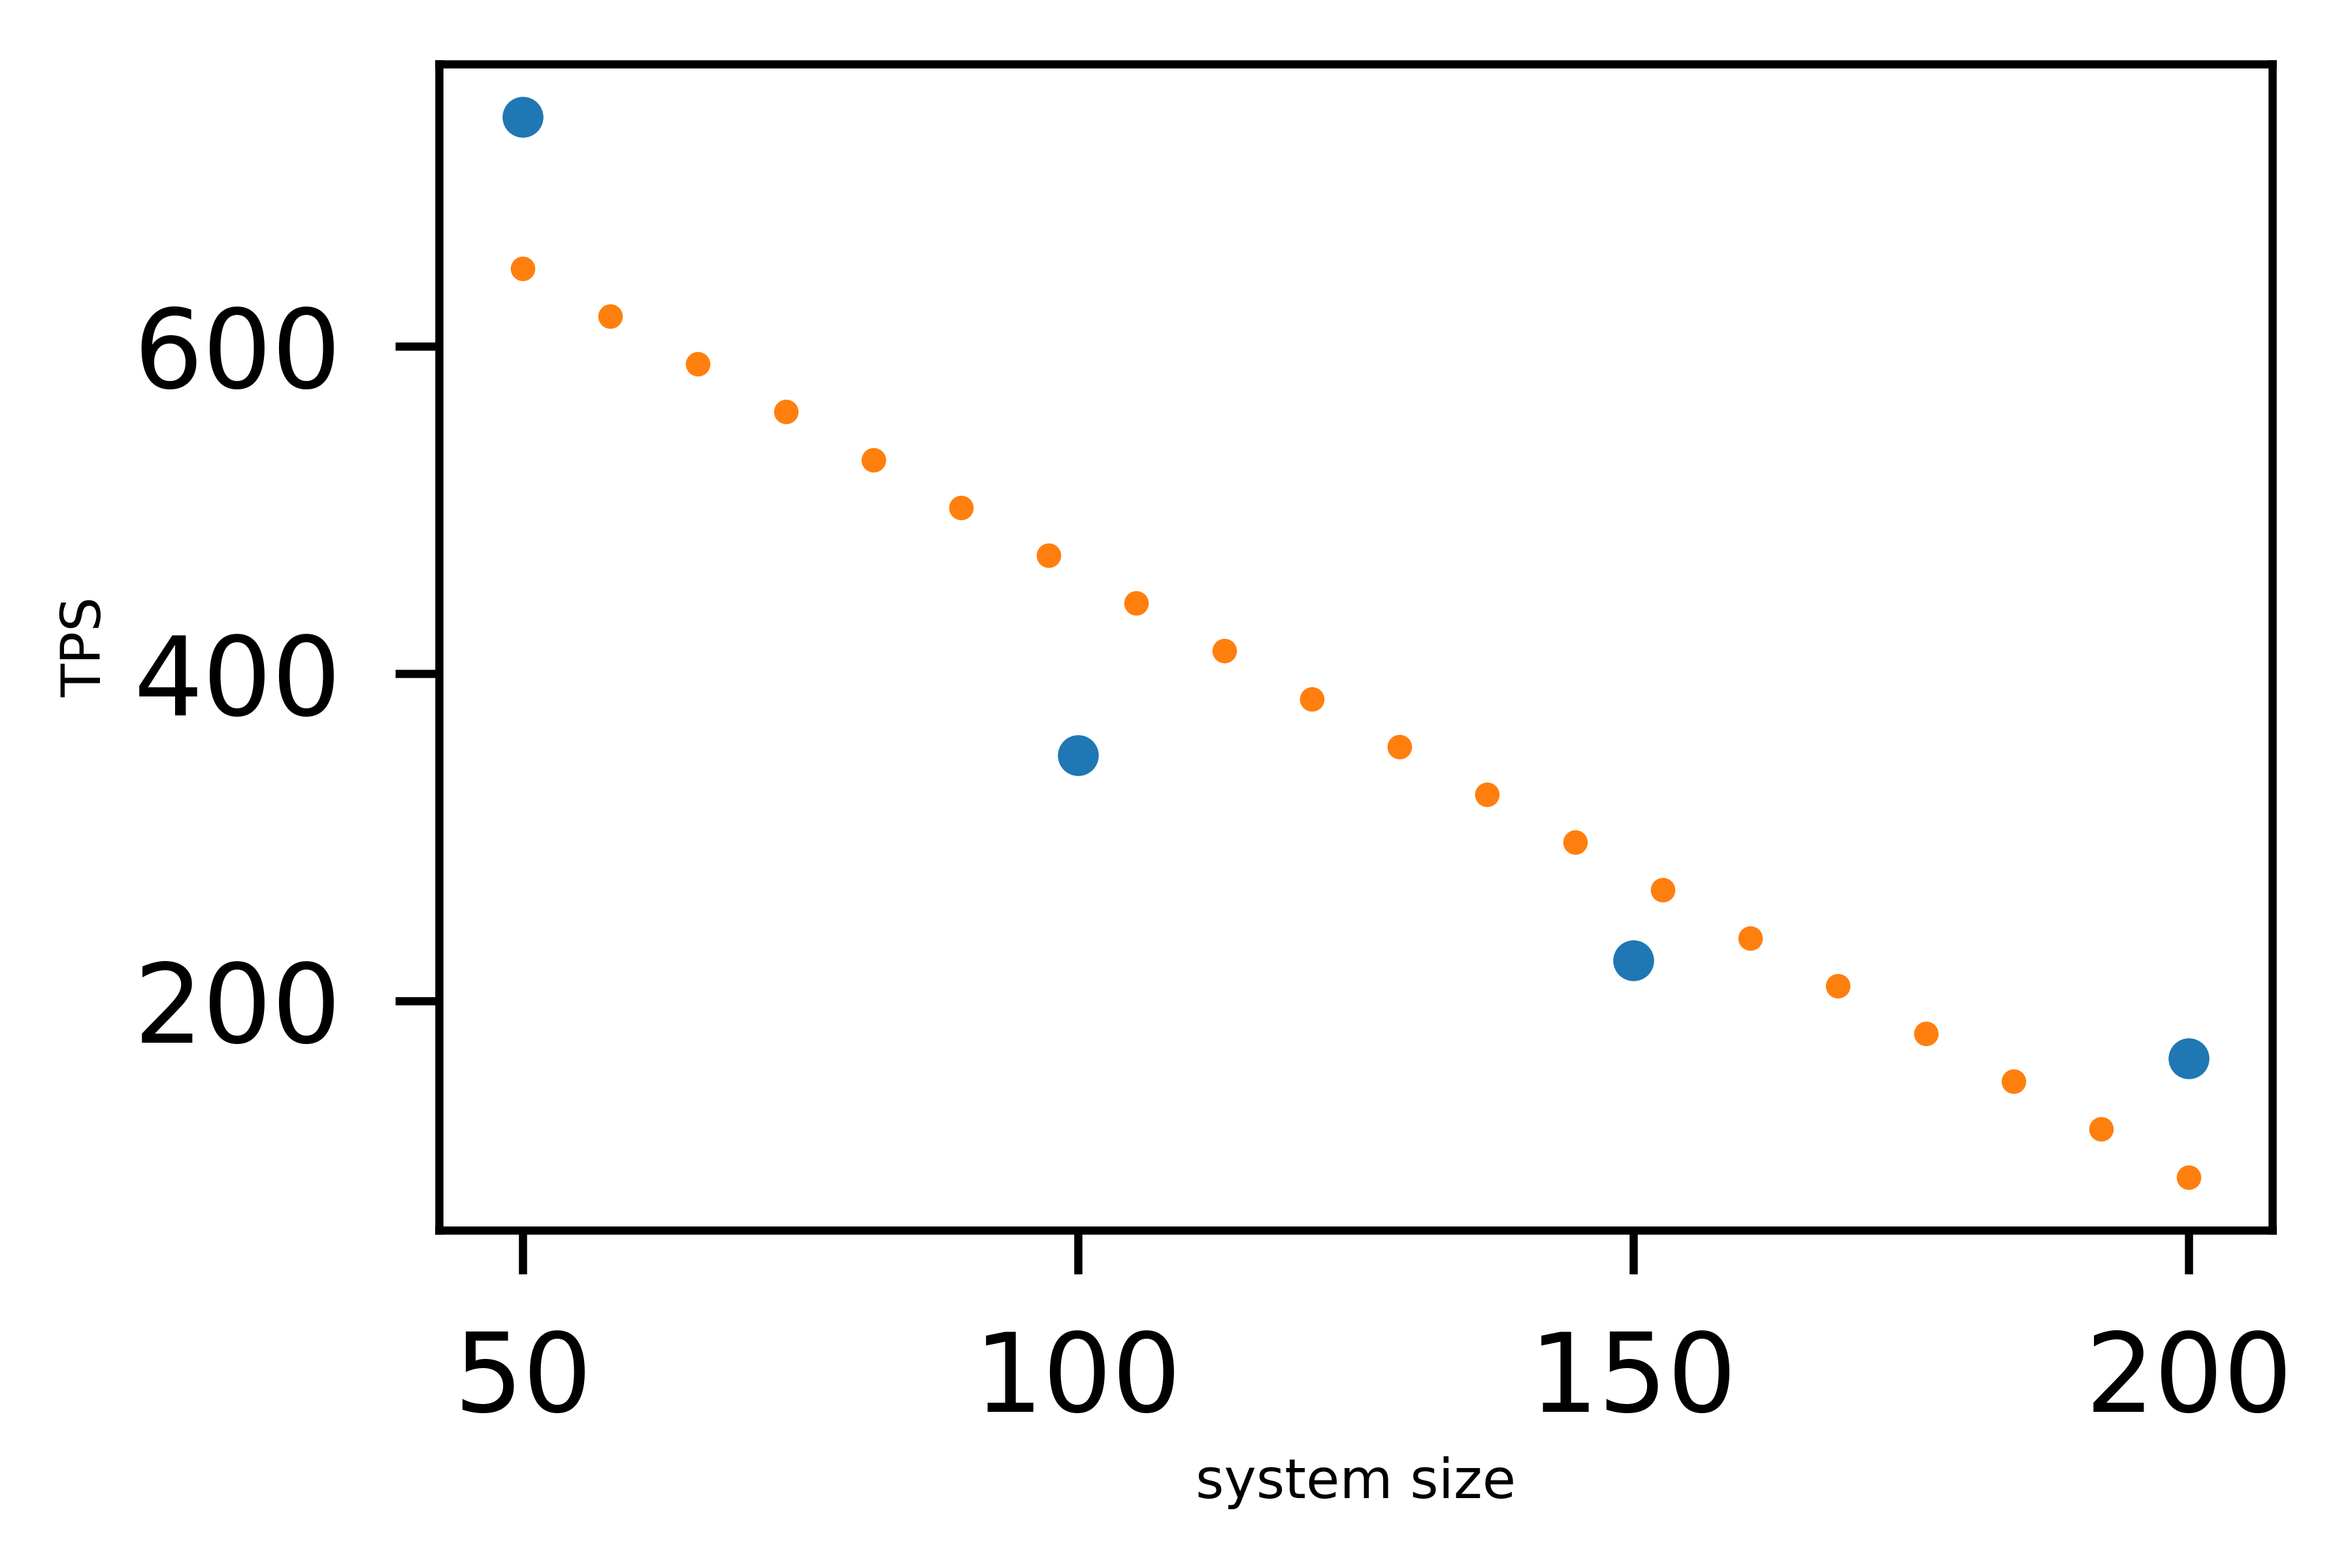

In [30]:
Image("TPSvSize.png")

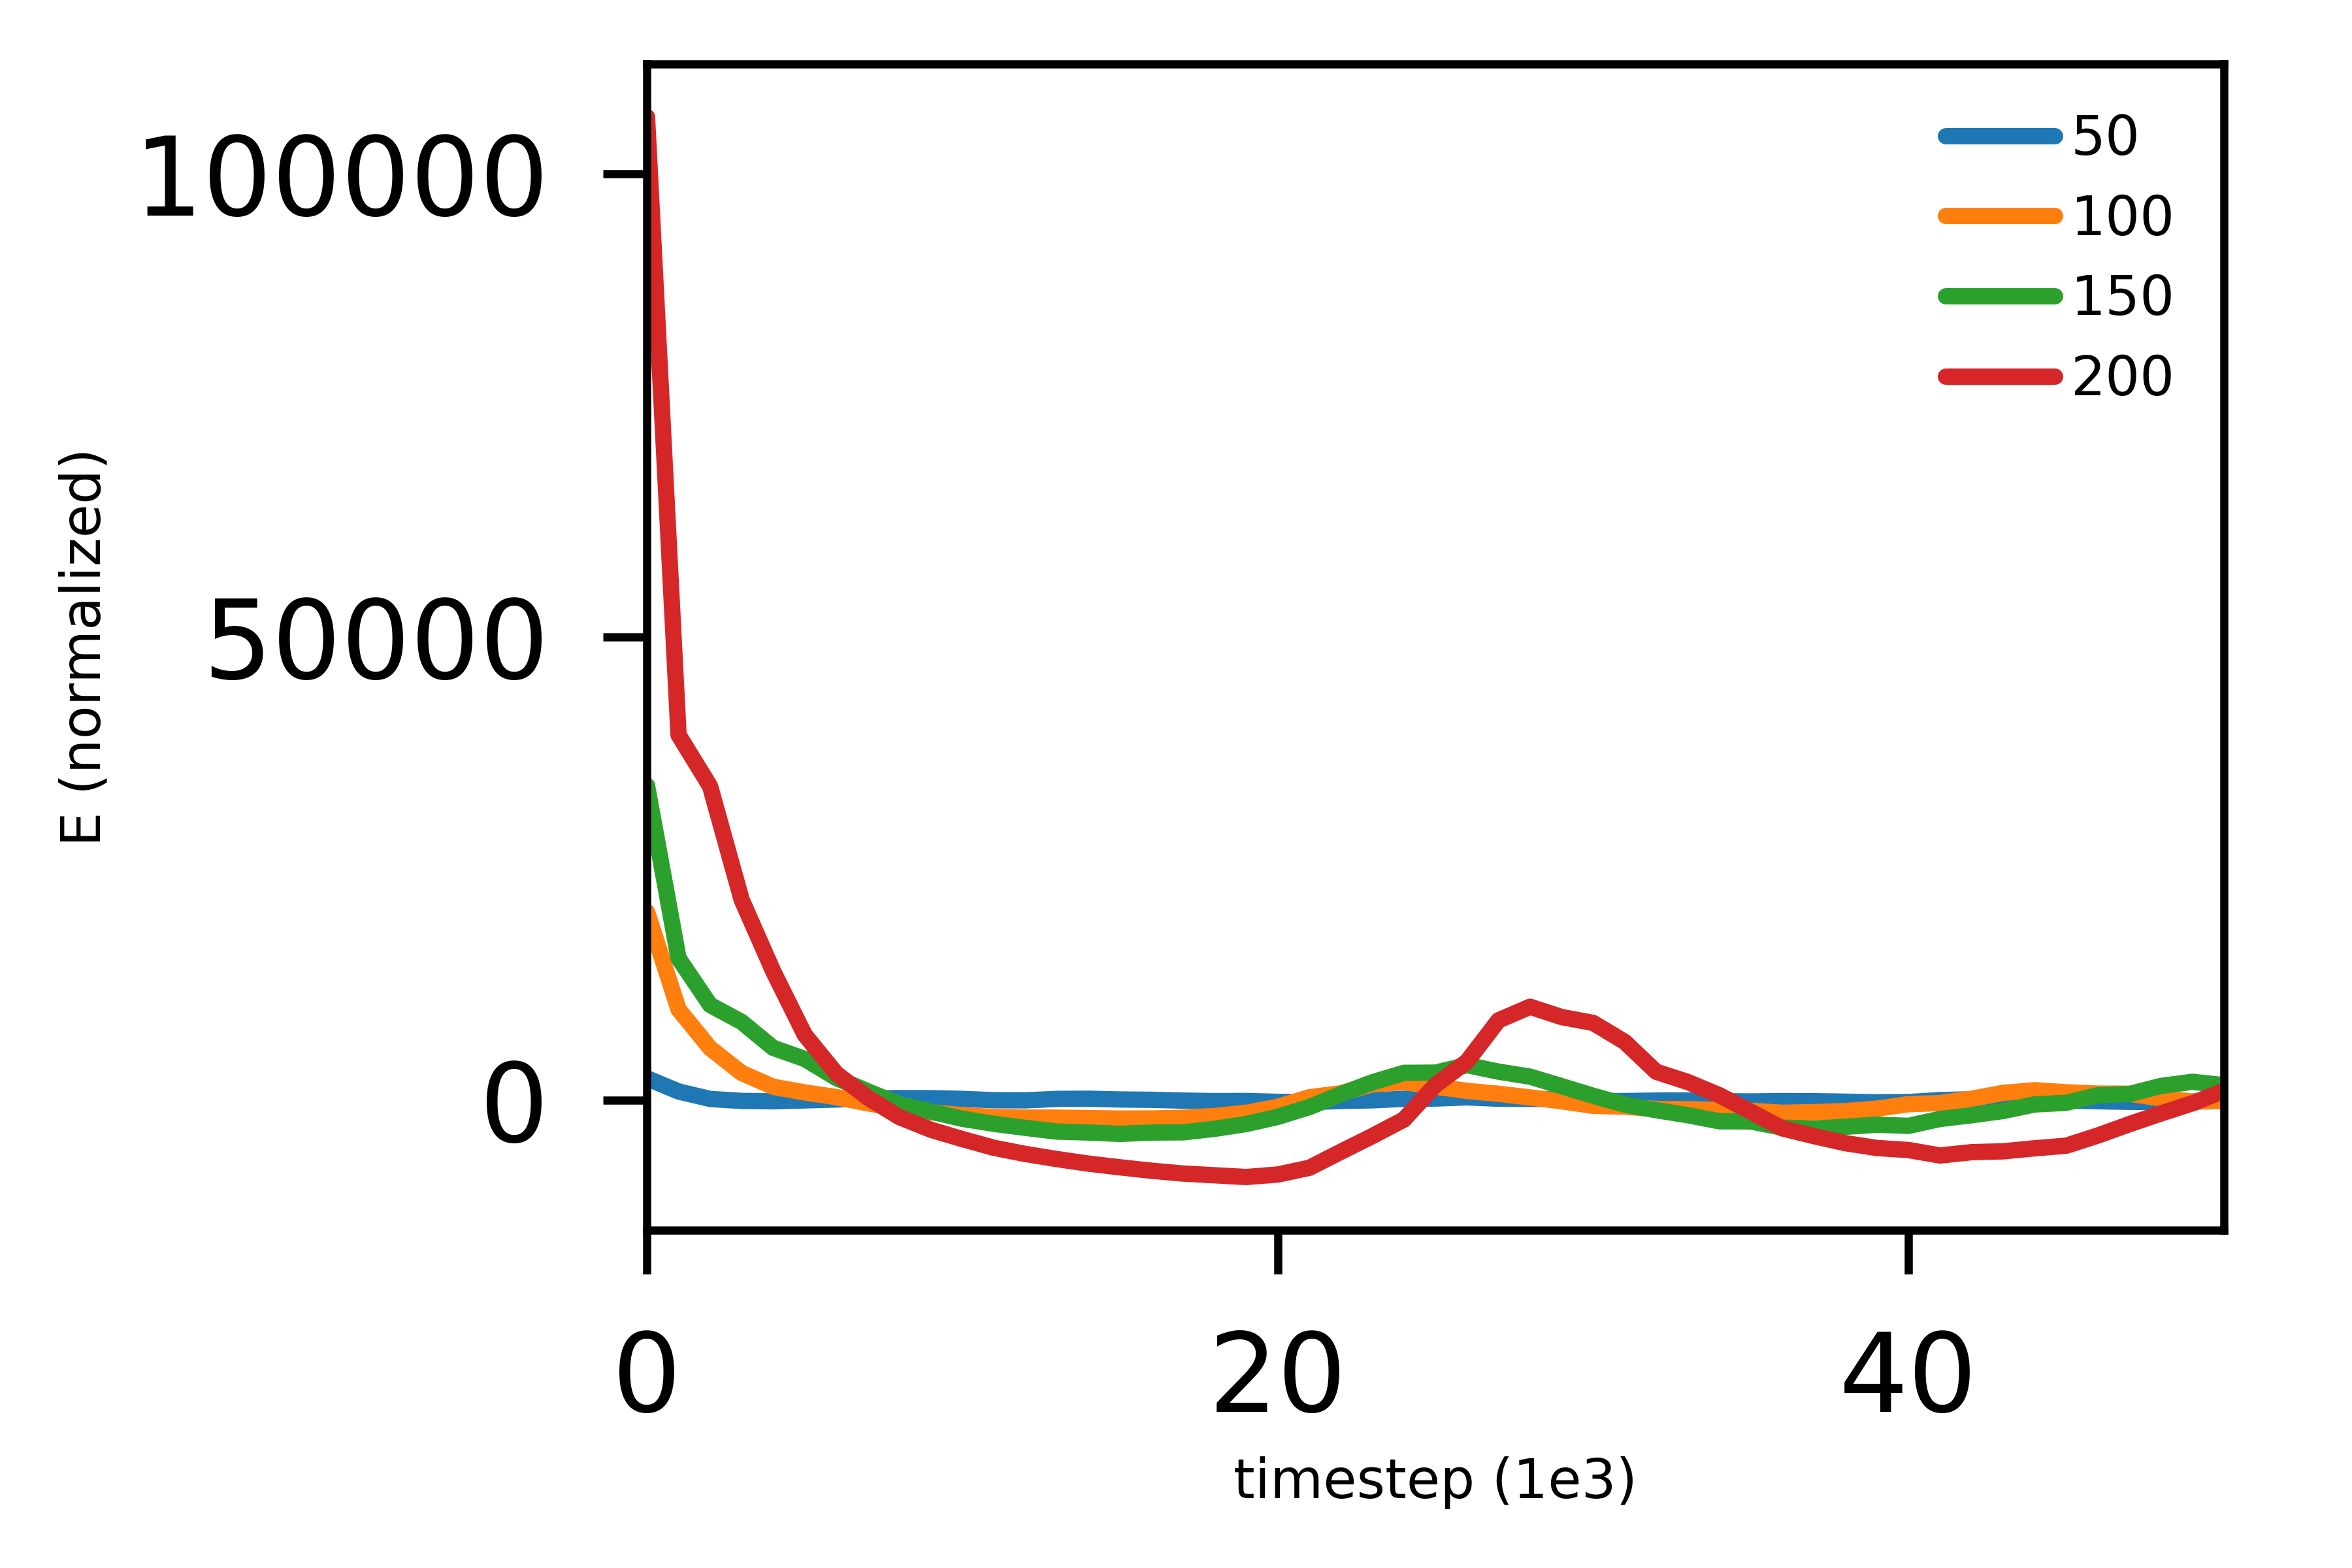

In [31]:
Image("EvT.png")

If we assume this trend represents the system for even larger system sizes we can use the equation of:

\begin{equation}
TPS(N) = 832.5 -3.7N,
\end{equation}

to calculate our TPS for our system.

If we assume a constant 20,000 timesteps to reach equilibrium, which would be a best-case senario, and say we want the system to calculate in six-hours or less we can calculate the mas system size as: N = 225. 
This number is too small, as the trend appears almost an exponential decay. 
When I fit an exponential or multi termed polynomial to the curve, the curve too doesn't provide good predictions either as it stabilizes too much e.g. I remains constant around 150 TPS or turns positive as N goes to infinity. 
Regardless, this model currently performs ineffeciently so large systems are currently anavailable to the code on my local machine. 
 
In terms of lower limits, the system needs to have a length of atleast 9.6 Angstroms in each direction.
When we give each molecule a length of 0.5 nm, the smallest system we could obtain was about 20 molecules before particles began to interact with themselves, which would cause HOOMD to crash.

The potential energy has an odd behavior in that every 20k timesteps the potential energy jumps back up. 
I think this behavior is arising from the thermostat putting energy into the system every once and a while, which with the carbons weighing so much less than the uranium, causes the carbons to move abruptly and distorts the bonds.
When this is visualized, there are no visual differences in the location of the Uranium atoms. 
These perturbations to the potential energy are quickly dissapated and the system returns to the stable or minimum potential energy again.


## 4

In calculating observables, I calculated the energy and the pressure of the system from the radial distribution function.


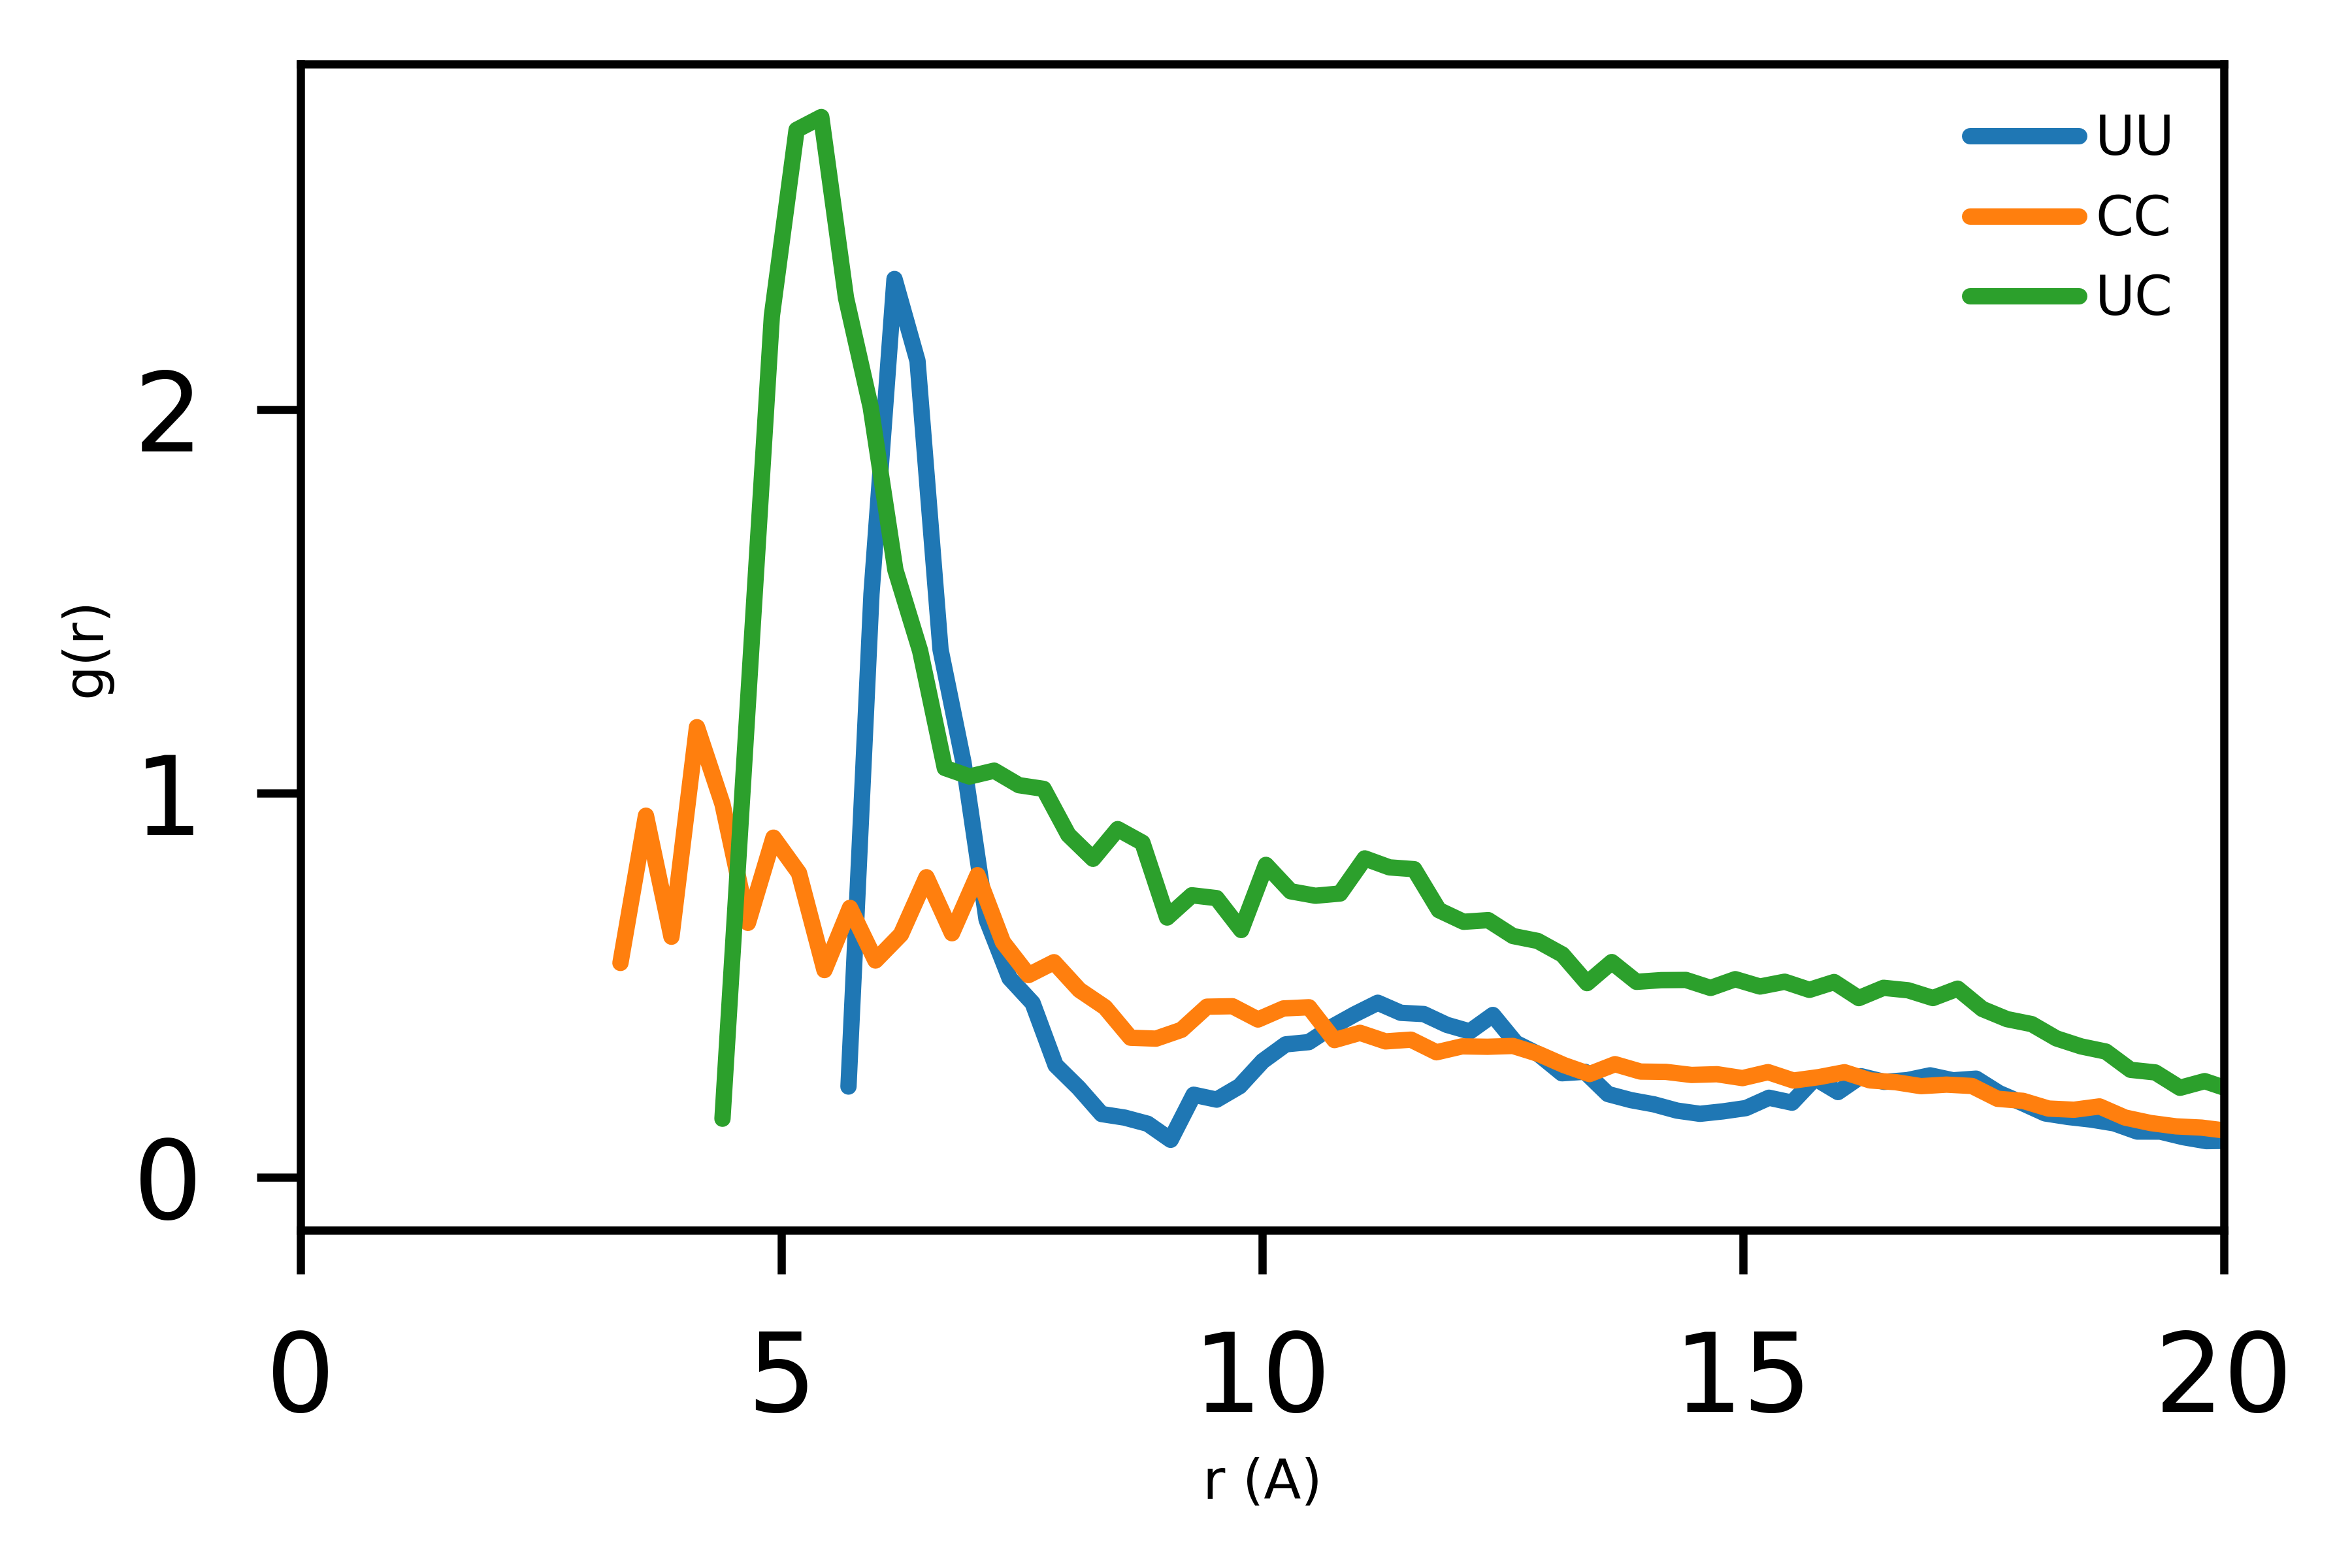

In [32]:
Image("normal.png")

The values I calculate are similar to those produced by HOOMD.
I calculate a pressure of 0.80 atm verses the 4.0 atm calculated in HOOMD. 
The energy I calculate is 45482 kJ/mol versus the 59375 kJ/mol that is calculated in HOOMD.
There will be error in my energy calculation due to the electrostatic energy contribution only extending for half the simulation volume, rather than the more robust electrostatic summations such as pppm.

Having a positive energy isn't super odd, since it appears the system is dominated by the repulsive core interactions, however the magnitude of the energy is odd.
I do think the magnitude of repulsive energy in the system is due to the issues of reduced and SI units, since getting the units into HOOMD, especially those of charge, seem to be much smaller than they should be in comparison to the core resulsions.
In playing around a bit with the interactions, even when I increase the electrostatic potential relative to the other portions by 10,000 the electrostatic interactions are still negligible. 
And it's hard to justify why the electrostatic attractions should be dominant when we have (1e-19)^2 in the numerator of the energy calculation, compared to the other terms.
Additionally, they don't condisder the permitivity of free space in their equation, which would increase the energy contribution from electrostatics by a factor of 10$^{12}$.

The experimentally measured crystal structure of U-C is a rock-salt structure. 
These structures with ions normally form due to the electrostatic interactions.
In our system, We see in the RDF there is a periodic structure that emerges in the Uranium, however it appears that this structure seems to form in order to minimize the repulsions rather than maximize the attractions. 
The carbon atoms still seems to be mostly random within the simulations. 
This is likely due to them being attached to the uranium atoms via bonding, but being randomly oriented, relative to eachother. 
I include an image of this below.

I also calculate the specific heat by fitting the Non-Bonded potential energy vs. T curve with a fourth order polynomial:

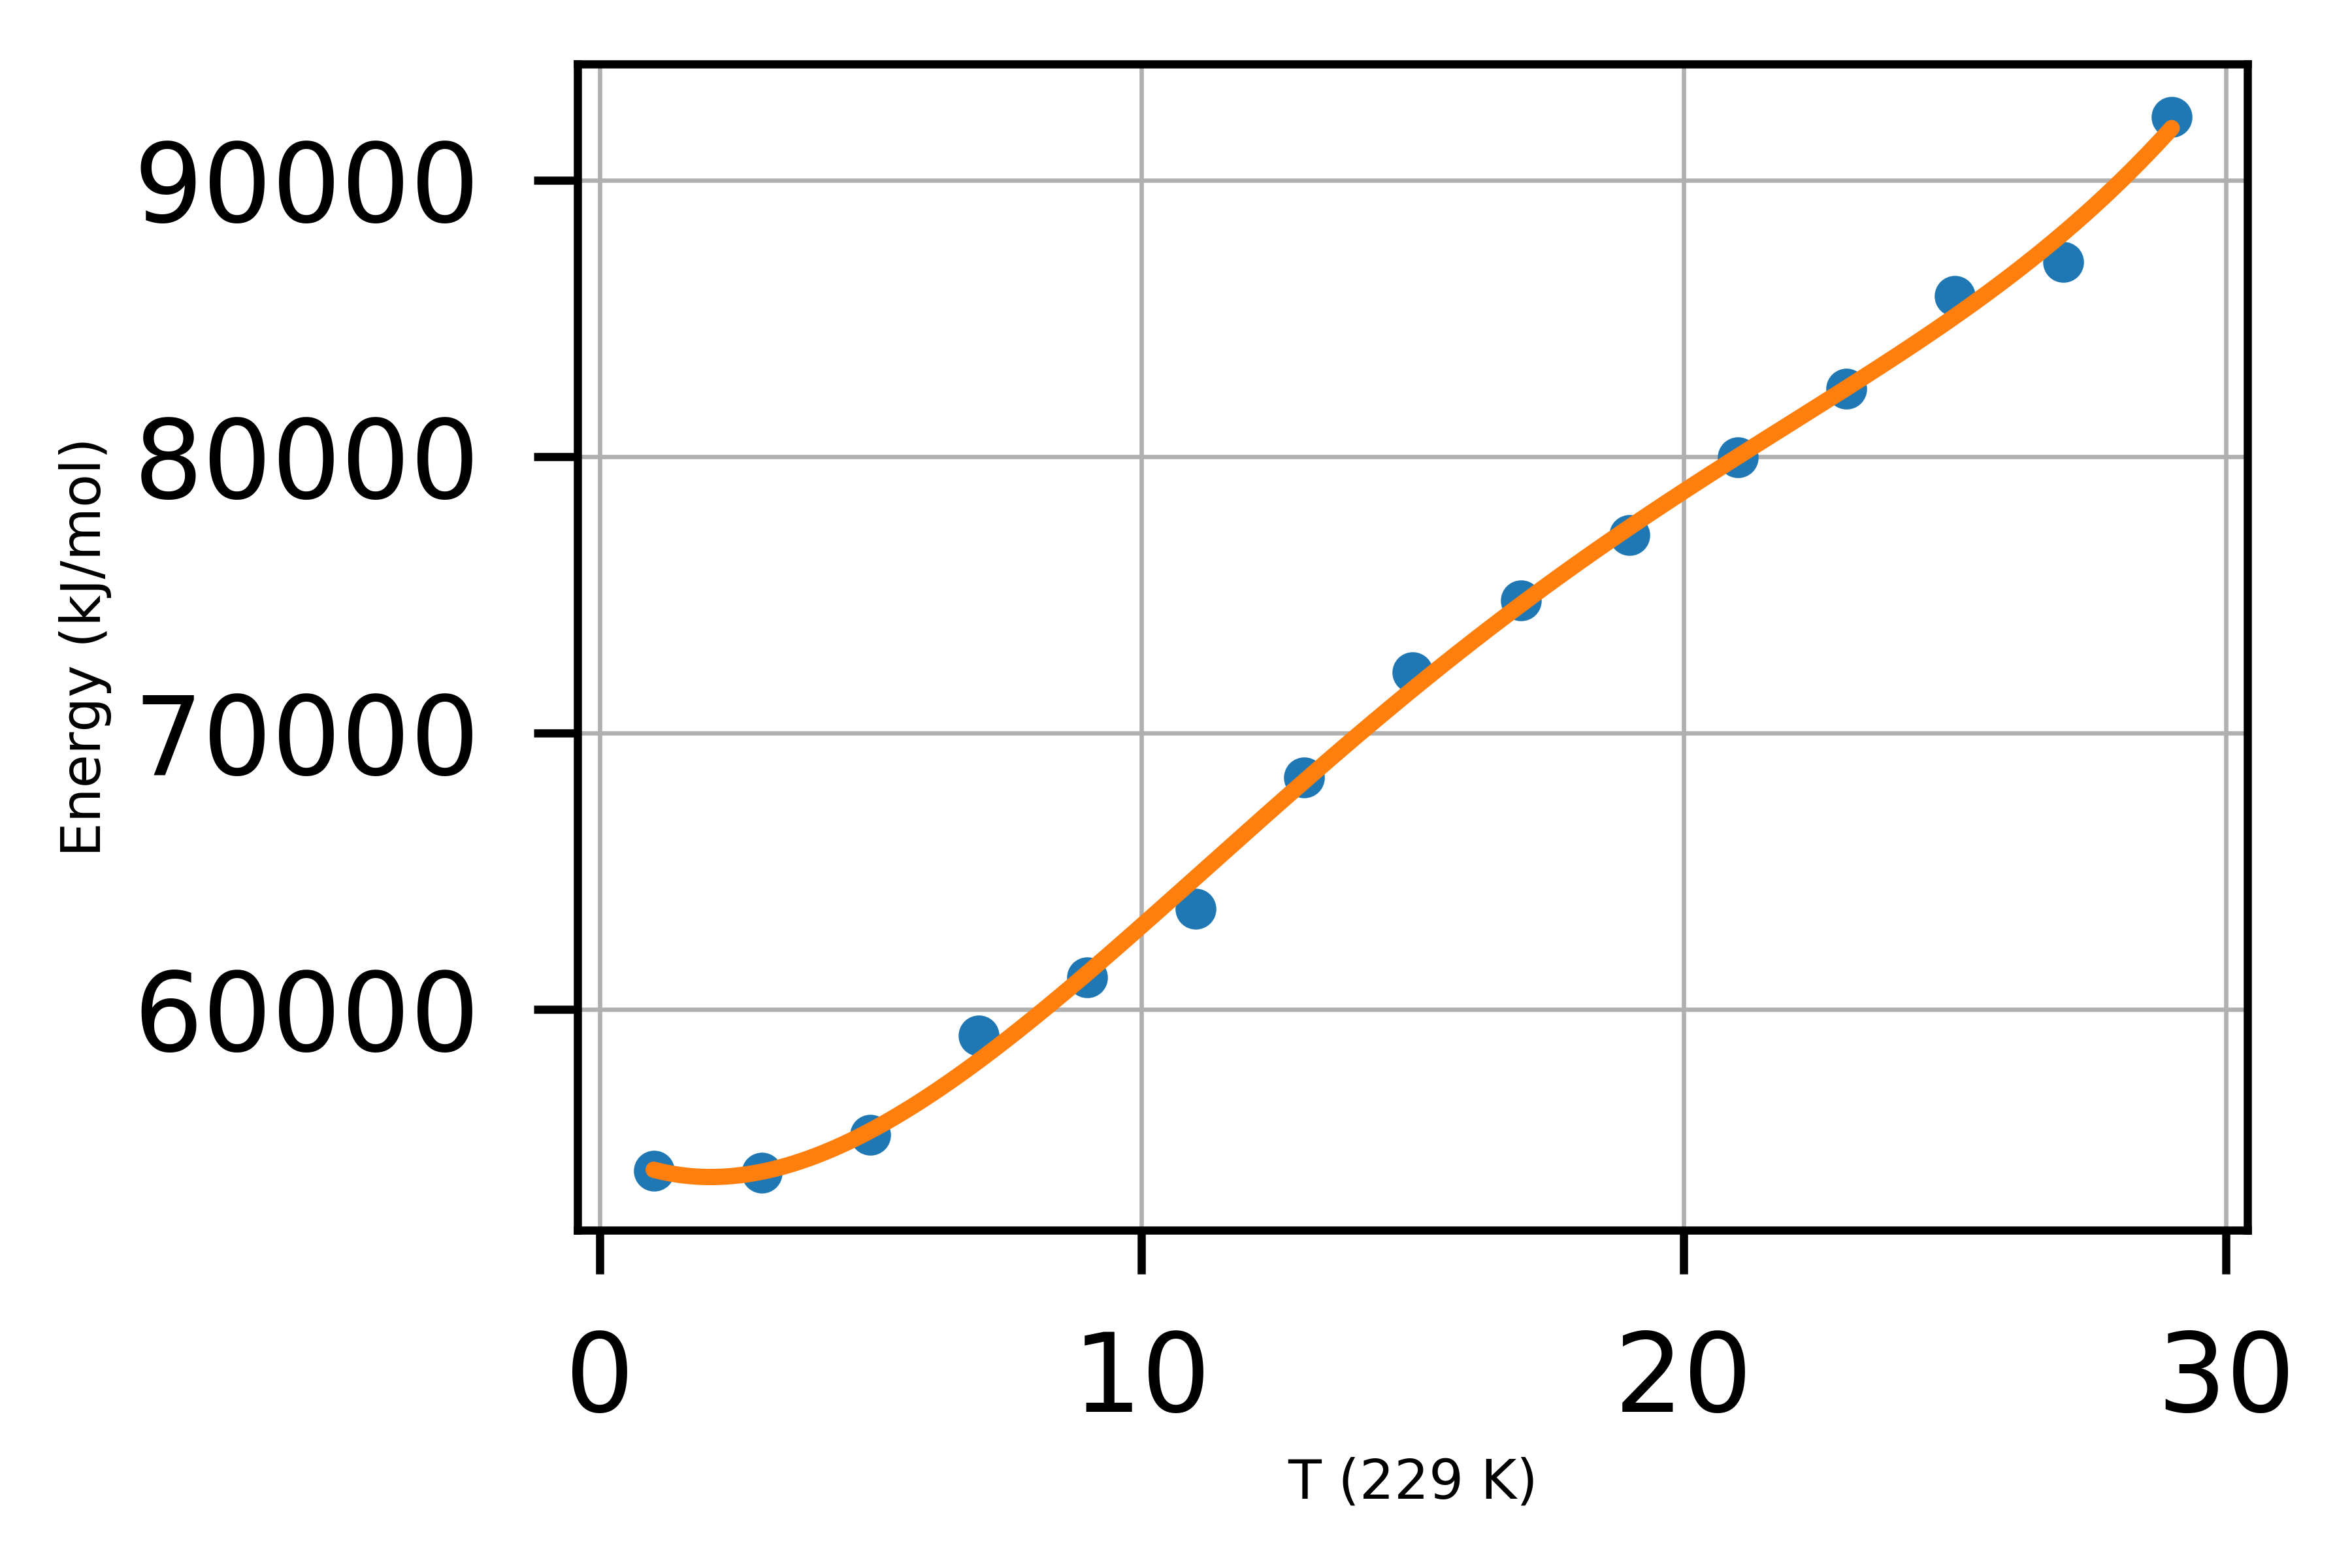

In [36]:
Image("UVT.png")

since C$_V$ is defined as $\frac{dU}{dT}$, we get: 

\begin{equation}
\frac{dU}{dT} = Cv = -1086.5 + 601 T - 41.1 T^2 + 0.83 T^3
\end{equation}

Each dT=1 is a temperature change of 229 K.
There appears to be a possible phase change at T=5. 
I say possible because of the change in the slope of the E vs. T curve, however there isn't much change in the radial distribution.
Uranium Carbide has been measured as having a melting temperature at 2600 K, and even when we go to a temperature of  ~6000 K, the first peak in the g(r) remains.
This supports the observation earlier that this system is being dominated by the repulsive Uranium cores.
Additionally, as we plot the Pressure vs Temperaure, there is a linear dependence between temperature and pressure. 


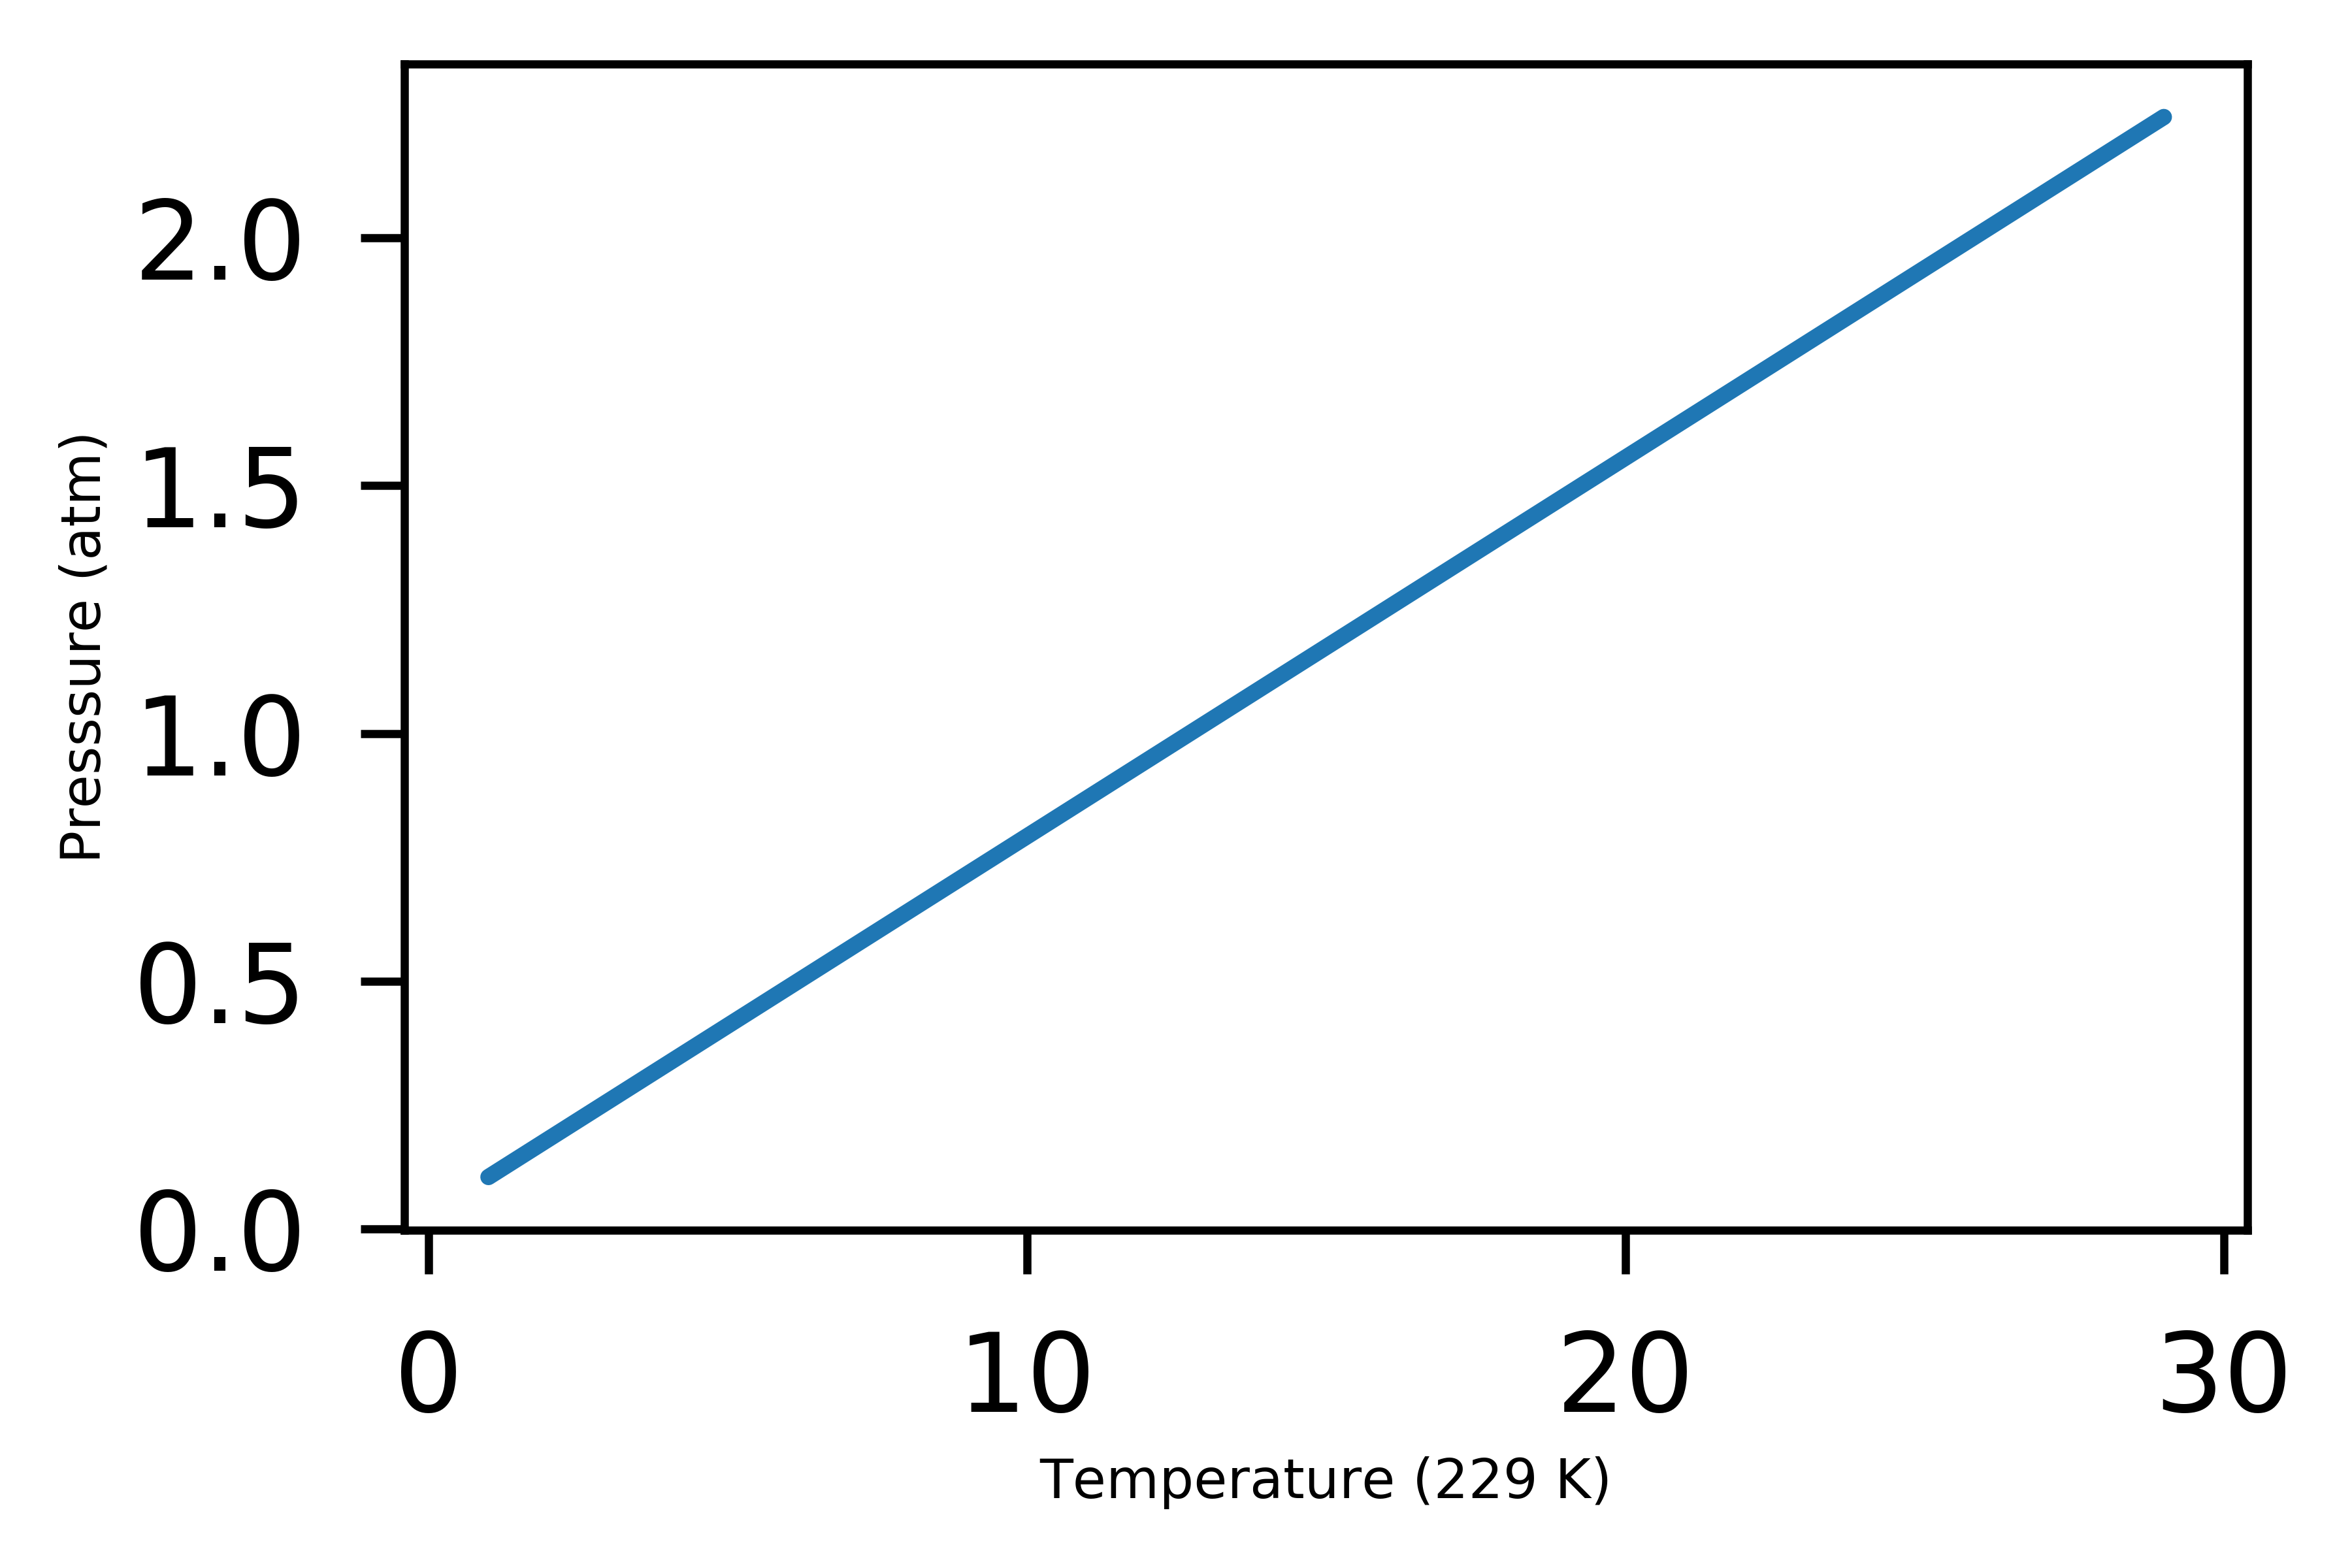

In [37]:
Image("PvT.png")

This is likely caused by the locations of the atoms, incorporated in the non-bonded potentials, are not changed significantly as the temperature increases.

One observation that can be gathered from this research is the importance of electrostatics.
Since we are trying to use the tabulated potential as it is presented, and HOOMD uses reduced units there is a discontinuity in reducing the units to produce the expected results.
As a consequence, we fail to see the rock-salt crystal structure form.
The emergence of the rock-salt structure should be dominated by the electrostatics, however as we have troubles finding the correct balance, it highlights the importance of the balance(s) of the various interactions.

Another observation in this model is the effects of inertia in the uranium and carbon atoms.
Although there is significant movement in the carbons, there is very little movement in uranmium even as we go to very high temperatures.
With this in mind, I am curious how ''strong'' the rock-crystal structure is, as in how much are the surrounding carbons stationary and how much are they able to move from lattice site to site?
In this system, I wonder in how far it is inaccurate to represent the U-C bonds are actual bonds, but rather would it be more accurate to represent them as separate carbon and uranium atoms?

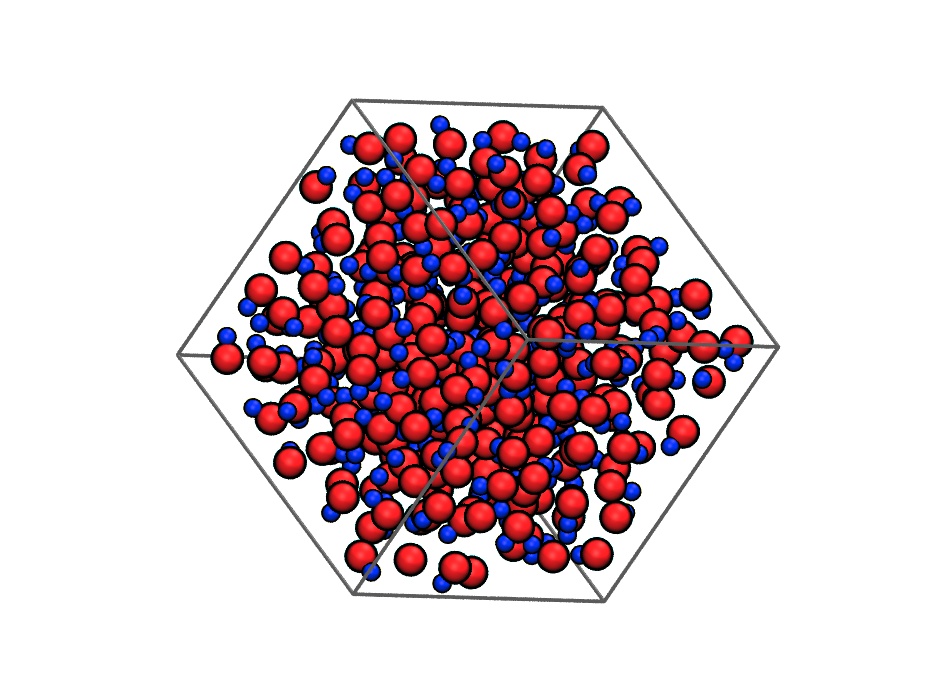

In [38]:
Image("UC.png")

## 5

For my alternative potential, I wanted to observe the coulombic interactions.
Therefore, I created potential that as a repulsive force at short distances, but is zero beyond the van der Waals radius.
The bond constraints are the same as were used in the previous potential and charge interactions are calculated using HOOMD's built in pppm method.

Similarly to the energy calculations above, due to the pressence of the charges the efficiency of the calculations is low.
Consequently, only smaller system sizes are investigated. 

The pair energies for this system is still high.
We calculate 4.5e7 kJ/mol as the pair potential for this system, whereas hoomd calculated 5.2e5 kJ/mol.
Therefore, our calculations are significantly higher than those calculated in HOOMD. 
In terms of pressure, we calcate a pressure of 0.49 atm, which is high comparable to the 0.014 atm calculated in HOOMD.
In the radial distribution function, the large nearest-neighbor peak isn't as obvious as it was in the cases of the previous potential.

One challenge in modeling the U-C system is due to the mass disparity between carbon and uranium. 
As these system try to relax, much of the movement is isolated to the carbons, and although, a minimum is reached, I am dubious if this is a true equalibrium or if the uranium atoms need to be able move more than they are able to in the time the simulation runs.


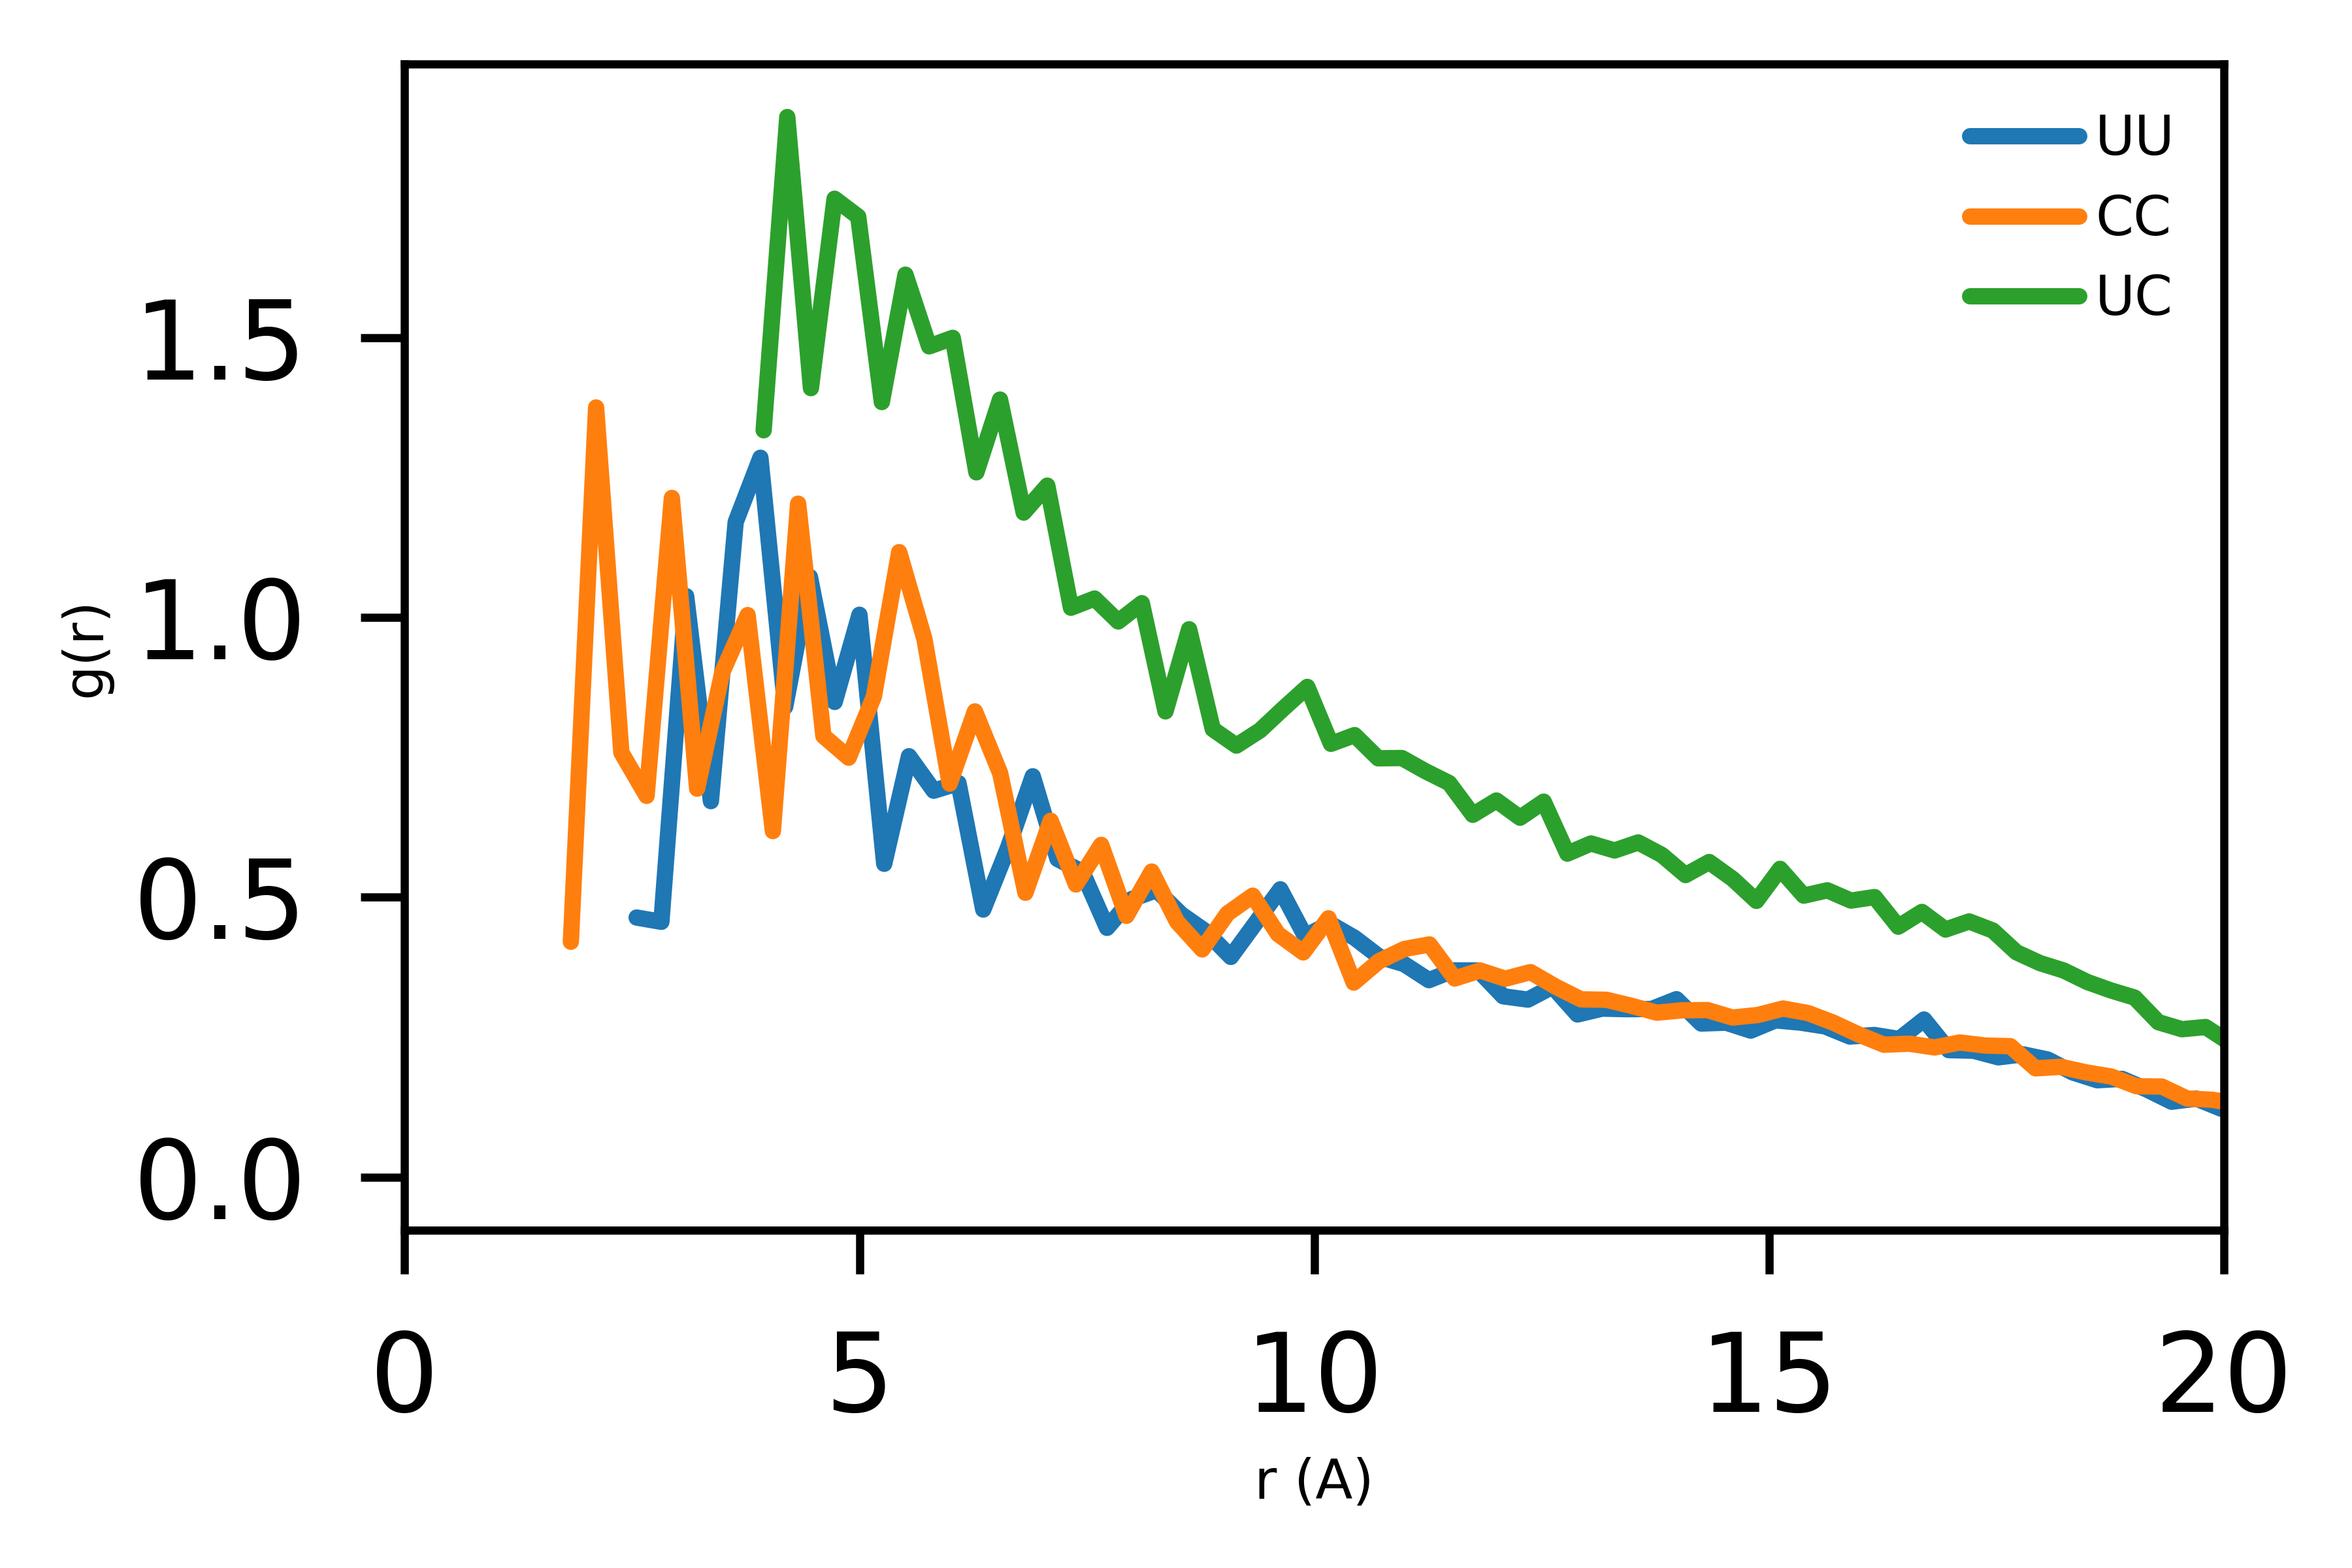

In [39]:
Image("updated.png")

In addition to using an alternative force-field, I also simulate the system in which no potentials are applied to the bonds.
In doing this we calculate an energy of 30607.12 kJ/mol and a pressure of 0.90 atm at T=12. 
When looking at the radial distribution function, the organization of the peaks is much nicer than that of the other systems, in fact there is a much stronger nearest neighbor peak and an emergence of a second nearest neighbor peak.
Therefore, the self-assembly of the system may be enhanced by the omittance of the bonds.

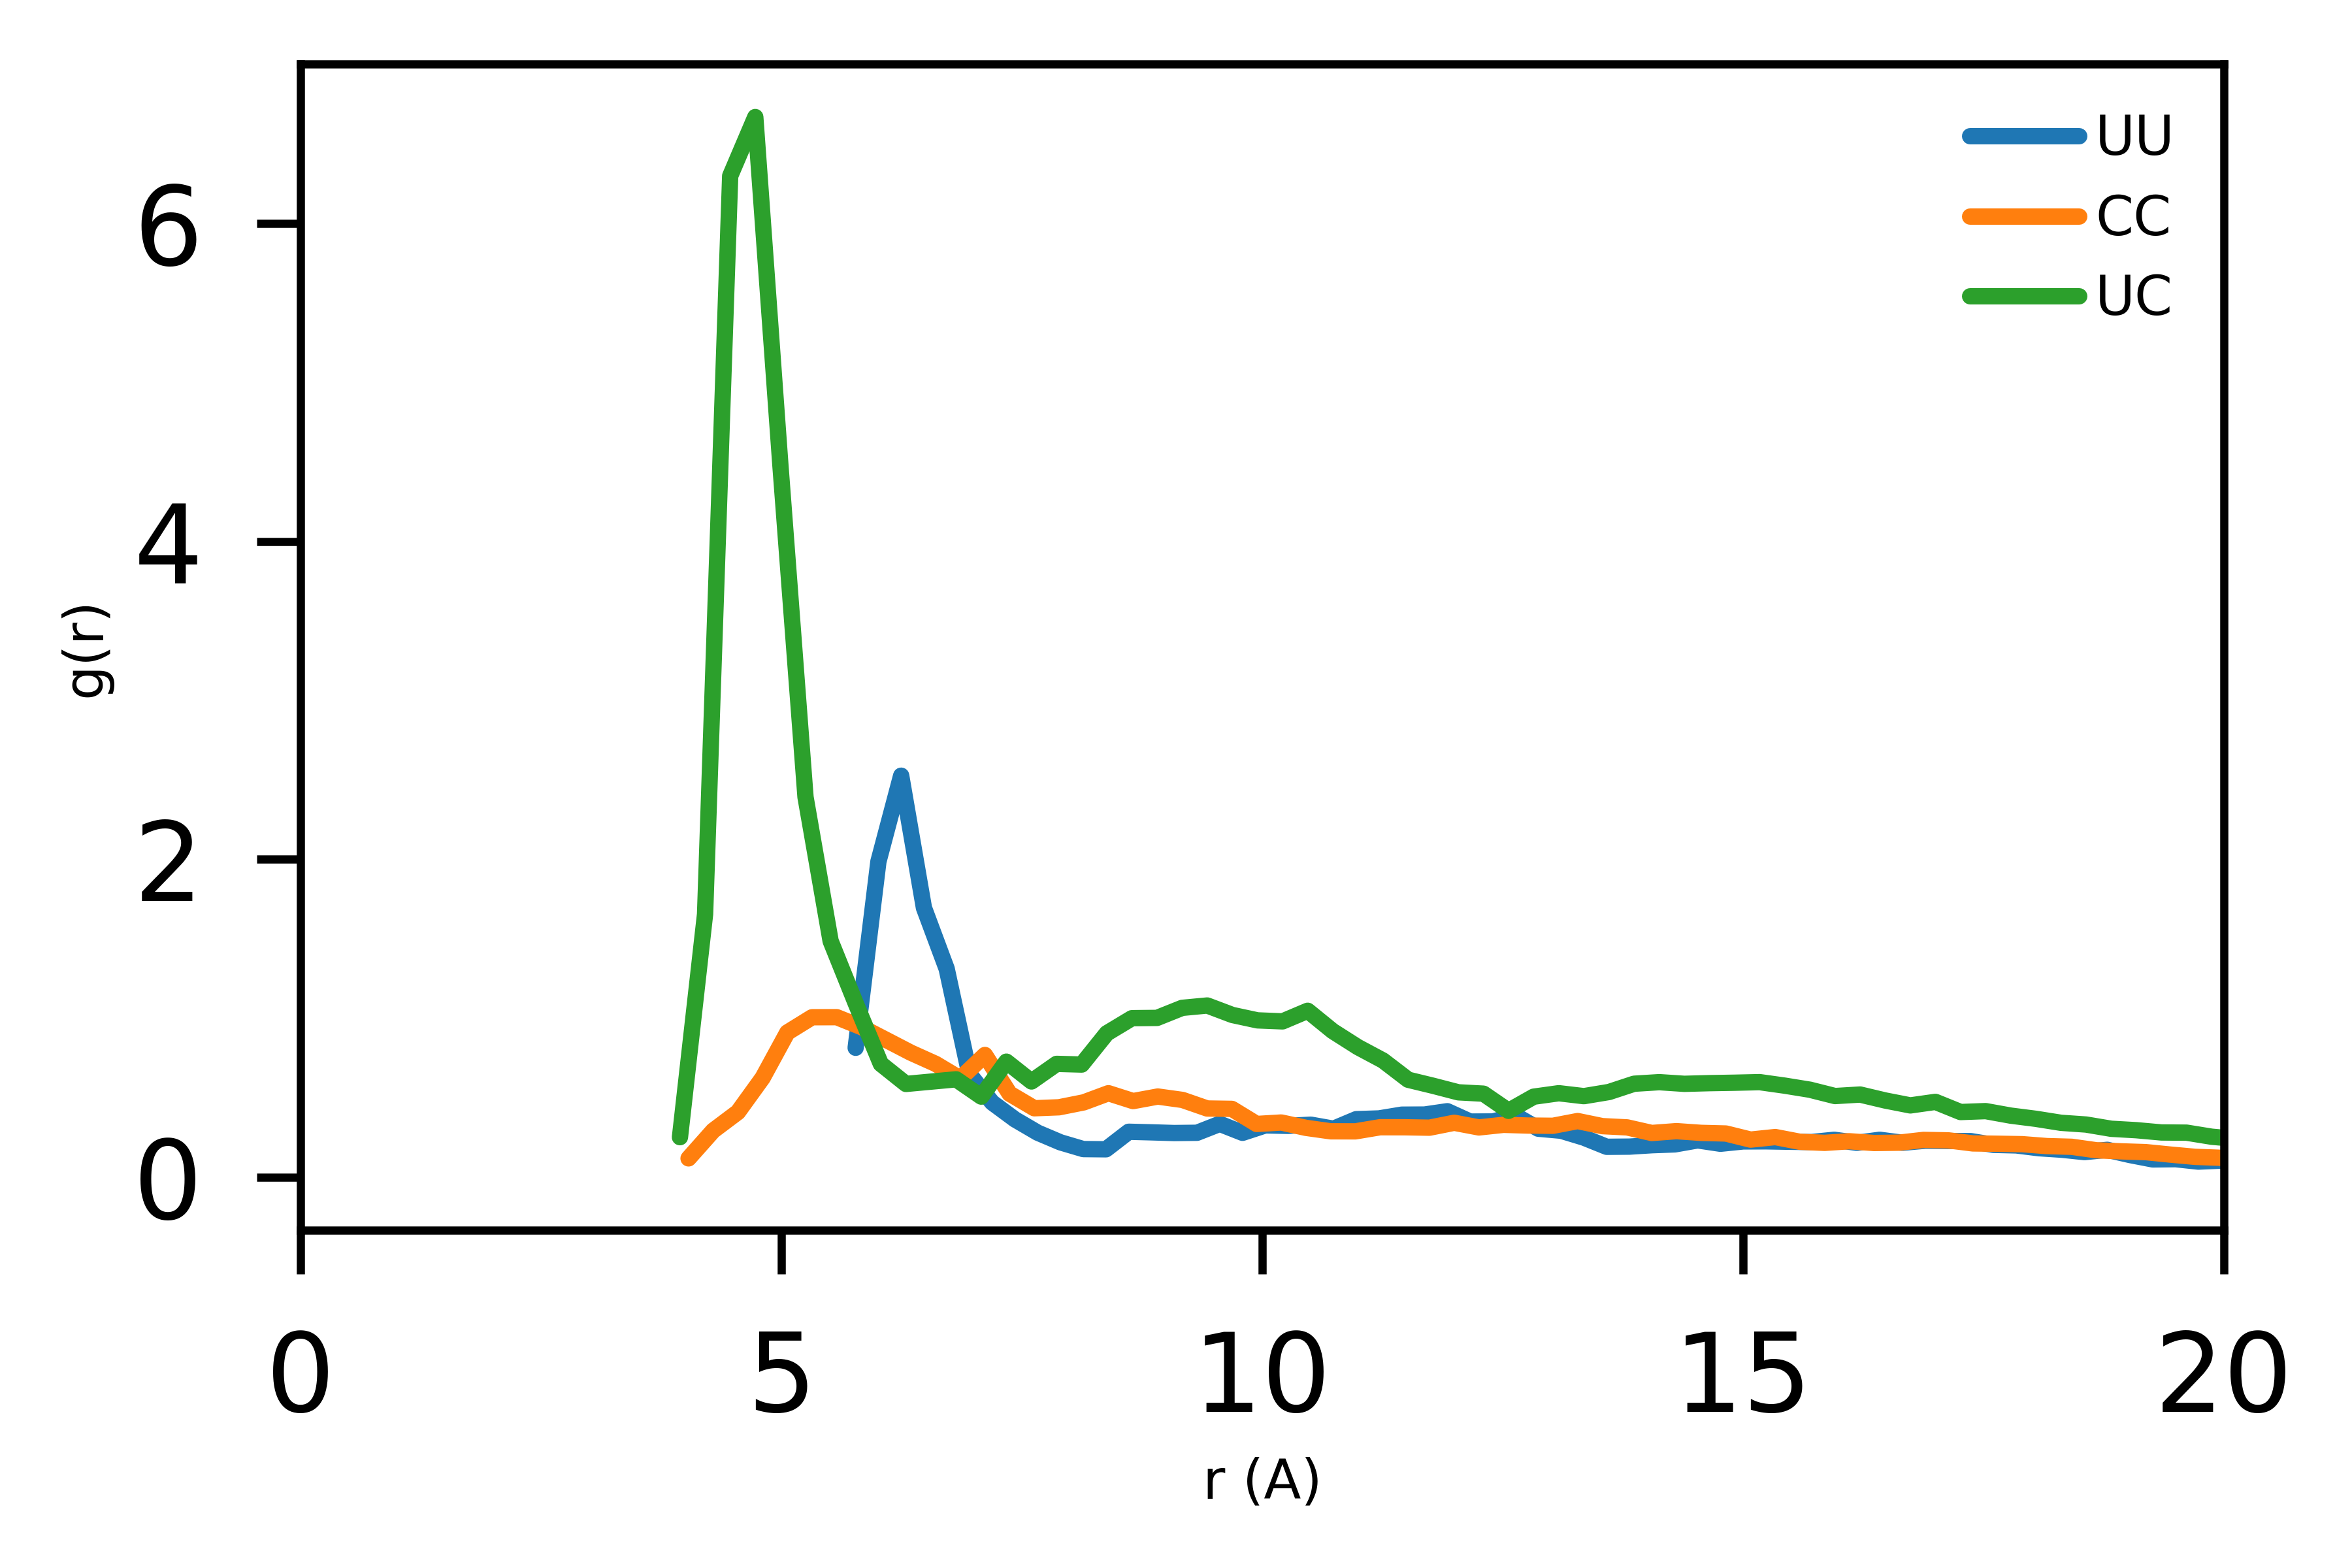

In [40]:
Image("nobond.png")